In [1]:
import numpy as np
import pandas as pd
from fredmd import FredMD
import sklearn.pipeline as skpipe
import sklearn.decomposition as skd
import sklearn.preprocessing as skp
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.utils.extmath import randomized_svd
from tqdm.notebook import tqdm

In [2]:
from datetime import datetime

In [3]:
bp_normalization = 1/1e-4

# Data Loaders

In [313]:
chen_z_port_data = pd.read_csv("data/allportretbase.csv", engine='python', 
                                       parse_dates=True, infer_datetime_format=True,
                               index_col=0)

In [314]:
chen_z_port_data.loc[:10]

date  port  signalmean       ret signalname
1   1952-01-28     1   -0.128123 -2.072024    ChInvIA
2   1952-01-28     2    0.265369 -1.587302    ChInvIA
3   1952-01-28     3    0.756904  3.234022    ChInvIA
4   1952-01-28     4    1.111943  5.087797    ChInvIA
5   1952-01-28     5    1.380300  0.394038    ChInvIA
6   1952-02-28     1   -2.906005 -1.830112    ChInvIA
7   1952-02-28     2   -0.128123 -3.502564    ChInvIA
8   1952-02-28     3    0.356002 -1.160923    ChInvIA
9   1952-02-28     4    0.916078 -3.703403    ChInvIA
10  1952-02-28     5    1.337499 -1.932206    ChInvIA

In [65]:
port_data = pd.read_csv("data/Decile370.csv", engine='python', 
                                       parse_dates=True, infer_datetime_format=True,
                               index_col=0)

In [85]:
port_data

Accrual1  Accrual2  Accrual3  Accrual4  Accrual5  Accrual6  Accrual7  \
date                                                                           
Jul-63 -0.012826 -0.034808 -0.003191 -0.005275  0.010313  0.005888  0.004184   
Aug-63  0.067188  0.074105  0.066497  0.058775  0.053321  0.045613  0.049207   
Sep-63  0.027254 -0.036808 -0.024923 -0.021495 -0.028114 -0.021926  0.008113   
Oct-63  0.000835  0.018107  0.052037  0.028497  0.019787  0.000345  0.033382   
Nov-63 -0.007417  0.006189 -0.005866 -0.013071 -0.004134 -0.010927  0.022306   
...          ...       ...       ...       ...       ...       ...       ...   
Aug-16 -0.009580  0.013689 -0.004262  0.006301 -0.006209 -0.007078 -0.020432   
Sep-16  0.022891  0.019072  0.001450  0.001660  0.005454  0.006495 -0.006051   
Oct-16 -0.044740 -0.041350 -0.024877 -0.031474 -0.022424 -0.021534 -0.025399   
Nov-16  0.063440  0.059874  0.045255  0.032907  0.048802  0.022360  0.019122   
Dec-16  0.003363  0.002639  0.002178  0.019369  0.004332  0.022383  0.022864   

        Accrual8  Accrual9  Accrual10  ...   valuem1   valuem2   valuem3  \
date                                   ...                                 
Jul-63 -0.016238 -0.006730   0.007966  ... -0.005697  0.012406  0.001231   
Aug-63  0.068175  0.045803   0.069205  ...  0.058840  0.052608  0.055026   
Sep-63  0.001662 -0.001641  -0.001218  ... -0.007272 -0.020598 -0.029426   
Oct-63  0.026131  0.068521   0.138922  ...  0.040936  0.069947  0.010846   
Nov-63  0.016902 -0.006462  -0.065160  ... -0.016181 -0.006102 -0.006735   
...          ...       ...        ...  ...       ...       ...       ...   
Aug-16 -0.009033  0.007217  -0.003808  ... -0.015329  0.006997  0.002248   
Sep-16 -0.004750  0.017574   0.041365  ...  0.005431  0.000962  0.010039   
Oct-16 -0.030498 -0.011537  -0.023091  ... -0.033727 -0.021004 -0.024162   
Nov-16  0.016960  0.018425   0.021705  ...  0.027541  0.009421  0.019687   
Dec-16  0.015515  0.021939   0.003183  ...  0.006646  0.005197  0.019856   

         valuem4   valuem5   valuem6   valuem7   valuem8   valuem9  valuem10  
date                                                                          
Jul-63 -0.002801  0.013128  0.005920 -0.004062 -0.001742 -0.012473 -0.020016  
Aug-63  0.039151  0.054055  0.062676  0.071960  0.045191  0.071493  0.060551  
Sep-63 -0.003999 -0.005038 -0.008329 -0.020563 -0.014848  0.000508 -0.024918  
Oct-63  0.025450  0.016331  0.007977  0.013869  0.022360  0.012007  0.014457  
Nov-63  0.017465 -0.013274 -0.018216 -0.009178 -0.000289 -0.020128  0.009548  
...          ...       ...       ...       ...       ...       ...       ...  
Aug-16 -0.001834  0.003393 -0.004559 -0.020440 -0.006131  0.012537  0.020131  
Sep-16  0.005334  0.003166  0.008354  0.008784  0.018973  0.022829  0.011941  
Oct-16 -0.032973 -0.023411 -0.008481 -0.032088 -0.034087 -0.006343 -0.051080  
Nov-16  0.045884  0.030852  0.081194  0.064125  0.044704  0.048685  0.117017  
Dec-16  0.005009  0.008039  0.019160  0.016118  0.041421  0.032077  0.041860  

[642 rows x 370 columns]

In [4]:
from pandas.tseries.offsets import MonthEnd

In [5]:
def parse_fucked_dt_format(date_str):
    year = int(date_str[-2:])
    if year <= 20:
        year = 2000+year
    else:
        year = 1900+year
    return date_str[:-2] + str(year)

In [6]:
port_data.index = pd.to_datetime(port_data.index.map(parse_fucked_dt_format) ) + MonthEnd(1)

NameError: name 'port_data' is not defined

In [31]:
class Dec370PortData:
    
    def __init__(self, start_date='1963-07', end_date='2016-01', tgt_factor='mkt'):
        port_data = pd.read_csv("data/Decile370.csv", engine='python', 
                                       parse_dates=True, infer_datetime_format=True,
                               index_col=0)
        port_data.index = pd.to_datetime(port_data.index.map(parse_fucked_dt_format) ) + MonthEnd(1)
        port_data = port_data.loc[port_data.index >= start_date]
        port_data = port_data.loc[port_data.index < end_date]
        

        return_panel = port_data.to_numpy()
        tgt = None
        if tgt_factor in {'mkt', 'SMB', 'HML', 'CMA', 'RMW'}:
            int_start_date = int(start_date.replace('-', ''))
            int_end_date = int(end_date.replace('-', ''))
            ff_factors = pd.read_csv('data/F-F_Research_Data_5_Factors_2x3.CSV', skiprows=0,
                                       engine='python', parse_dates=True, infer_datetime_format=True)
            ff_factors = ff_factors.loc[ff_factors.date >= int_start_date] #NOTE not offsetting by one here across data sources
            ff_factors = ff_factors.loc[ff_factors.date < int_end_date]
            if tgt_factor == 'mkt':
                tgt = ff_factors['Mkt-RF'].to_numpy() / 100
            if tgt_factor == 'SMB':
                tgt = ff_factors['SMB'].to_numpy() / 100
            if tgt_factor == 'HML':
                tgt = ff_factors['HML'].to_numpy() / 100
            if tgt_factor == 'CMA':
                tgt = ff_factors['CMA'].to_numpy() / 100
            if tgt_factor == 'RMW':
                tgt = ff_factors['RMW'].to_numpy() / 100
            rf = np.expand_dims(ff_factors['RF'].to_numpy() / 100, axis=1)
        self.data = return_panel - rf, tgt, int(tgt.shape[0]/2)

In [111]:
dec_port_panel, tgt_factor, weak_test_start = Dec370PortData(tgt_factor=tgt).data

In [114]:
class ChenZData:
    
    def __init__(self, start_date='1976-03', end_date='2019-09', tgt_factor='mkt'):
        chen_z_port_data = pd.read_csv("data/allportretbase.csv", engine='python', 
                                       parse_dates=True, infer_datetime_format=True,
                               index_col=0)
        chen_z_port_data = chen_z_port_data.loc[chen_z_port_data.date >= start_date]
        chen_z_port_data = chen_z_port_data.loc[chen_z_port_data.date < end_date]

        chen_z_port_data['port_id'] = chen_z_port_data.signalname.add(chen_z_port_data.port.astype(str))
        chen_z_port_data.port_id = chen_z_port_data.port_id
        portfolios = sorted(chen_z_port_data.port_id.unique())
        dates = chen_z_port_data.date.unique()
        portfolios = [p for p in portfolios if 
                     np.sum(chen_z_port_data['port_id'] == p) == len(dates)]
        return_panel = np.zeros((len(dates), len(portfolios)), dtype=float)
        for i, pname in enumerate(portfolios):
            return_panel[:, i] = chen_z_port_data.loc[chen_z_port_data['port_id'] == pname].ret.to_numpy()
        tgt = None
        if tgt_factor in {'mkt', 'SMB', 'HML', 'CMA', 'RMW'}:
            int_start_date = int(start_date.replace('-', ''))
            int_end_date = int(end_date.replace('-', ''))
            ff_factors = pd.read_csv('data/F-F_Research_Data_5_Factors_2x3.CSV', skiprows=0,
                                       engine='python', parse_dates=True, infer_datetime_format=True)
            ff_factors = ff_factors.loc[ff_factors.date >= int_start_date] #NOTE not offsetting by one here across data sources
            ff_factors = ff_factors.loc[ff_factors.date < int_end_date]
            if tgt_factor == 'mkt':
                tgt = ff_factors['Mkt-RF'].to_numpy() / 100
            if tgt_factor == 'SMB':
                tgt = ff_factors['SMB'].to_numpy() / 100
            if tgt_factor == 'HML':
                tgt = ff_factors['HML'].to_numpy() / 100
            if tgt_factor == 'CMA':
                tgt = ff_factors['CMA'].to_numpy() / 100
            if tgt_factor == 'RMW':
                tgt = ff_factors['RMW'].to_numpy() / 100
            rf = np.expand_dims(ff_factors['RF'].to_numpy() / 100, axis=1)
        self.data = return_panel / 100 - rf, tgt, int(tgt.shape[0]/2)

# Models


##  SPCA

In [359]:


class SPCA:
    
    def __init__(self, data_panel, target_panel, n_train,
                N_factor=6) -> None:
        """
        Auguments:
        1) data_panel: numpy 2d array of data, normalizations and transforms should have already been applied
        2) target_panel: numpy 2d array of target data, normalizations and transforms should have already been applied
        3) n_train: index of start of oos
        4) N_factors: number of factors
        """
        self.n_factors = N_factor
        self.test_start = n_train
        self.data_series = np.copy(data_panel)
        self.tgt_series = np.copy(target_panel)
        
    def fit(self, nlags, true_oos=False, pca=False, raw_data=None,
           stack_lags=False, plot_resids=False, fit_factors_epanding_window=True,
           print_res=False, rp_pca=0):
        
        T, N = self.data_series.shape
        
        
        scaled_data = np.copy(self.data_series[:self.test_start,:])
        scaled_data_full = np.copy(self.data_series)
        
        gamma_is = SPCA.get_gamma_is(scale(scaled_data), self.tgt_series[:self.test_start])
        if pca:
            gamma_is[:] = 1
        gamma_is = np.diag(gamma_is)
        _, loadings = SPCA.fit_factors(scaled_data@gamma_is, self.n_factors, rp_pca=rp_pca)
        
        gx_factors, _, gx_loadings = SPCA.fit_factors_gx(scaled_data.T, self.tgt_series[:self.test_start].T,
                            self.n_factors)

        factors = (scaled_data_full - np.mean(scaled_data_full[:self.test_start],
                                              axis=0, keepdims=True)) @ loadings
            
        #R2
        A_fit = np.concatenate([factors[:self.test_start], np.ones((self.test_start, 1))], axis=1)
        A_test = np.concatenate([factors[self.test_start:],
                                 np.ones((factors[self.test_start:].shape[0], 1))], axis=1)
        fit_target = self.tgt_series[:self.test_start]
        test_target = self.tgt_series[self.test_start:]
        reg_loadings = np.linalg.lstsq(A_fit, fit_target, rcond=None)[0]
        is_r2 = r_squared(A_fit, reg_loadings, fit_target, np.mean(fit_target))
        r2 = r_squared(A_test, reg_loadings, test_target, np.mean(fit_target))
        
        bhat = self.test_start * loadings @ np.linalg.solve(factors[:self.test_start].T @ factors[:self.test_start], 
                                                    loadings.T @ np.mean(scaled_data_full[:self.test_start], axis=0))
        
        gx_is_sharpe = bhat @ np.mean(scaled_data_full[:self.test_start], axis=0) / np.sqrt(bhat @
                                                            np.cov(scaled_data_full[:self.test_start].T)
                                                              @ bhat)
        gx_oos_sharpe_true = bhat @ np.mean(scaled_data_full[self.test_start:], axis=0) / np.sqrt(bhat @
                                                            np.cov(scaled_data_full[self.test_start:].T)
                                                              @ bhat)
        
        bhat_oos = loadings @ np.linalg.solve(factors[self.test_start:].T @ factors[self.test_start:], 
                                                    loadings.T @ np.mean(scaled_data_full[self.test_start:], axis=0))
        gx_oos_sharpe = bhat_oos @ np.mean(scaled_data_full[self.test_start:],
                                                axis=0) / np.sqrt(bhat_oos @
                                                                  np.cov(scaled_data_full[self.test_start:].T
                                                                        ) @ bhat_oos)
        
        
        if print_res:
            print("gx sharpes ", gx_is_sharpe, gx_oos_sharpe)

        w_mark = markowitz(factors[:self.test_start])
        is_sharpe = sharpe(factors[:self.test_start], w_mark)
        oos_sharpe = sharpe(factors[self.test_start:], w_mark)
        is_factor_mean = np.mean(factors[:self.test_start], axis=0)
        oos_factor_mean = np.mean(factors[self.test_start:], axis=0)
        
#         is_rpremia, true_oos_rpremia = estimate_rpremia(scaled_data_full[:self.test_start]@loadings,
#                                                       loadings, scaled_data_full[:self.test_start], 
#                                      fit_target, scaled_data_full[self.test_start:])
        is_rpremia, true_oos_rpremia = estimate_rpremia(factors[:self.test_start],
                                                      loadings, scaled_data_full[:self.test_start], 
                                     fit_target, scaled_data_full[self.test_start:])
#         oos_rpremia = estimate_rpremia(scaled_data_full[self.test_start:]@loadings, loadings,
#                                        scaled_data_full[self.test_start:], 
#                                      test_target)
        oos_rpremia = estimate_rpremia(factors[self.test_start:], loadings,
                                       scaled_data_full[self.test_start:], 
                                     test_target)
    
        
#         is_xs_rmse_alpha = xs_rmse_alpha(factors[:self.test_start], scaled_data_full[:self.test_start])
        is_xs_rmse_alpha = xs_rmse_alpha(scaled_data_full[:self.test_start]@loadings,
                                         scaled_data_full[:self.test_start])
#         oos_xs_rmse_alpha = xs_rmse_alpha(factors[self.test_start:], scaled_data_full[self.test_start:])
        oos_xs_rmse_alpha = xs_rmse_alpha(scaled_data_full[self.test_start:]@loadings,
                                          scaled_data_full[self.test_start:])

        
#         is_test_asset_ev = test_asset_ev(factors[self.test_start:], scaled_data_full[self.test_start:])
        is_test_asset_ev = test_asset_ev(scaled_data_full[:self.test_start]@loadings, 
                                         scaled_data_full[:self.test_start])
#         oos_test_asset_ev = test_asset_ev(factors[:self.test_start], scaled_data_full[:self.test_start])
        oos_test_asset_ev = test_asset_ev(scaled_data_full[self.test_start:]@loadings,
                                          scaled_data_full[self.test_start:])
    
        sharpe_in, sharpe_out = sharpe_in_out(scaled_data_full[:self.test_start]@loadings,
                                             scaled_data_full[self.test_start:]@loadings)

        return  is_r2, r2, gx_is_sharpe, gx_oos_sharpe, gx_oos_sharpe_true, is_rpremia, \
                oos_rpremia, true_oos_rpremia,\
                is_xs_rmse_alpha, oos_xs_rmse_alpha, is_test_asset_ev, oos_test_asset_ev,\
                sharpe_in, sharpe_out, is_factor_mean, oos_factor_mean

        
    def fit_ts_reg(self, plot_resids=False):
        self.test_start
        gamma_is = SPCA.get_gamma_is(self.data_series[:self.test_start,:], self.tgt_series[:self.test_start])
        factors = SPCA.fit_factors(self.data_series*gamma_is, self.n_factors)[self.test_start:]
        loadings = np.linalg.lstsq(factors, self.tgt_series[self.test_start:], rcond=None)[0]
        preds = factors.dot(loadings)
        gts = self.tgt_series[self.test_start:]
        if plot_resids:
            plt.plot(preds - gts, label='factor resids')
            plt.legend()
            plt.show()
        
        print("r2 vs mean model", 1 - np.sum(np.square(preds - gts)) / np.sum(np.square(gts - np.mean(gts))))
        print("EV", 1 - np.sum(np.square(preds - gts)) / np.sum(np.square(gts)))
    

    @staticmethod
    def fit_factors(scaled_data, n_factors, rp_pca=0):
        T,N = scaled_data.shape

        fit_pipe = skpipe.Pipeline([('loadings', skd.TruncatedSVD(n_factors, algorithm='arpack'))])

        if rp_pca > 0:
            objective = scaled_data.T.dot(scaled_data) / T
            rbar = np.mean(scaled_data, axis=0, keepdims=True)
            objective += rp_pca * rbar.T @ rbar
        else:
            scaled_data = scaled_data - np.mean(scaled_data, axis=0, keepdims=True)
            objective = scaled_data.T.dot(scaled_data)
        loadings = fit_pipe.fit_transform(objective)
        factors = (1/N ) * scaled_data.dot(loadings)
        
        return factors, loadings
    
    
    @staticmethod
    def fit_factors_gx(scaled_data, tgt_data, n_factors, rp_pca=0):
        N,T = scaled_data.shape
        rbar = np.mean(scaled_data, axis=1, keepdims=True)
        scaled_data = scaled_data - rbar

        psi, singval, xi = randomized_svd(scaled_data, n_components=n_factors,
                                               n_iter=10, random_state=None)
        vhat = np.sqrt(T) * xi
        gamma_hat = np.sqrt(T) * np.diag(1/singval) @ psi.T@rbar
        eta_hat = (1/T) * (tgt_data - np.mean(tgt_data)) @ vhat.T
        
        return vhat, eta_hat, psi
        
    
    @staticmethod
    def get_gamma_is(data, target):
        loadings = []
        T = target.shape[0]
        
        for i in range(data.shape[1]):
            A = np.stack([data[:,i], np.ones(T)], axis=1)
            loading = np.linalg.lstsq(A, target, rcond=None)[0][0]
            loadings.append(loading)
        return np.array(loadings)

    

In [360]:


class GX_SPCA:
    
    def __init__(self, data_panel, target_panel, test_start, N_factors=6):
        """
        Auguments:
        1) data_panel: numpy 2d array of data, normalizations and transforms should have already been applied
        2) target_panel: numpy 2d array of target data, normalizations and transforms should have already 
            been applied
        3) n_train: index of start of oos
        4) N_factors: number of factors
        """
        T,N = data_panel.shape
        self.all_tgt = target_panel
        self.all_train = np.copy(data_panel)
        self.train_data = np.copy(data_panel[:test_start])
        self.train_target = target_panel[:test_start]
        self.test_data = np.copy(data_panel[test_start:])
        self.test_target = target_panel[test_start:]
        self.n_factors = N_factors
        
    def fit(self, nlags, true_oos=False, pca=False, raw_data=None,
           stack_lags=False, plot_resids=False, quantile=None, print_res=False,
           fit_factors_epanding_window=False, rp_pca_term=0, print_rp=True):
        
        T,N = self.all_train.shape
        
        T_train, N_train = self.train_data.shape
        T_test, N_test = self.test_data.shape
        
        if quantile is None:
            qtile_test_start = int(self.train_data.shape[0]/2)
            quantiles = [i*(1/50) for i in range(50)]
            qtuile_r2s = [GX_SPCA(self.train_data, self.train_target, 
                                  qtile_test_start, self.n_factors).fit(nlags=nlags, true_oos=True,
                                                                       quantile=q, 
                                                                        rp_pca_term=rp_pca_term,
                                                                       print_rp=False)[1] for q in quantiles]
            quantile = quantiles[np.argmax(qtuile_r2s)]
            print("chosen quantile:", quantile)
            
        betas, b_hats, fit_factors, gx_rpremia_is = GX_SPCA.get_portfolio_loadings(self.train_data, self.train_target, 
                                                                        self.n_factors,
                                              quantile=quantile, rp_pca_term=rp_pca_term,
                                              print_rp=print_rp)
        
        
        _, _, _, gx_rpremia_oos = GX_SPCA.get_portfolio_loadings(self.test_data, self.test_target, 
                                                                        self.n_factors,
                                              quantile=quantile, rp_pca_term=rp_pca_term,
                                              print_rp=print_rp)
        if print_rp:
            print(rp_pca_term, gx_rpremia_is, gx_rpremia_oos)
        
        train_factors = (self.train_data - np.mean(self.train_data, keepdims=True, axis=0)) @ b_hats
        test_factors = (self.test_data - np.mean(self.train_data, keepdims=True, axis=0)) @ b_hats
        
        
        
        #In sample R2
        A_fit = np.concatenate([train_factors, np.ones((train_factors.shape[0], 1))], axis=1)
        A_test = np.concatenate([test_factors, np.ones((test_factors.shape[0], 1))], axis=1)
        fit_target = self.train_target
        loadings = np.linalg.lstsq(A_fit, fit_target, rcond=None)[0]
        predicted = A_fit@loadings

        is_r2 = r_squared(A_fit, loadings, fit_target, np.mean(fit_target))
        r2 = r_squared(A_test, loadings, self.test_target, np.mean(fit_target))
 
        bhat = T_train * b_hats @ np.linalg.solve(train_factors.T @ train_factors, 
                                                    b_hats.T @ np.mean(self.train_data, axis=0))
        
        gx_is_sharpe = bhat @ np.mean(self.train_data, axis=0) / np.sqrt(bhat @ np.cov(self.train_data.T) @ bhat)
        gx_oos_sharpe_true = bhat @ np.mean(self.test_data, axis=0) / np.sqrt(bhat @ np.cov(self.test_data.T) @ bhat)
        
        bhat_oos = T_test * b_hats @ np.linalg.solve(test_factors.T @ test_factors, 
                                                    b_hats.T @ np.mean(self.test_data, axis=0))
        gx_oos_sharpe = bhat_oos @ np.mean(self.test_data,
                                                axis=0) / np.sqrt(bhat_oos @ np.cov(self.test_data.T) @ bhat_oos)
        
        if print_res:
            print("gx sharpes ", gx_is_sharpe, gx_oos_sharpe)
        
        w_mark = markowitz(train_factors)
        is_sharpe = sharpe(train_factors, w_mark)
        oos_sharpe = sharpe(test_factors, w_mark)
        is_factor_mean = np.mean(train_factors, axis=0)
        oos_factor_mean = np.mean(test_factors, axis=0)
        
        is_rpremia, true_oos_rpremia = estimate_rpremia(train_factors, b_hats, self.train_data, 
                                     self.train_target, self.test_data)

        oos_rpremia = estimate_rpremia(test_factors, b_hats, self.test_data, 
                                     self.test_target)        
        
#         is_xs_rmse_alpha = xs_rmse_alpha(train_factors, self.train_data)
        is_xs_rmse_alpha = xs_rmse_alpha(self.train_data @ b_hats, self.train_data)
#         oos_xs_rmse_alpha = xs_rmse_alpha(test_factors, self.test_data)
        oos_xs_rmse_alpha = xs_rmse_alpha(self.test_data @ b_hats, self.test_data)
        
#         is_test_asset_ev = test_asset_ev(train_factors, self.train_data)
        is_test_asset_ev = test_asset_ev(self.train_data @ b_hats, self.train_data)
    
        if print_res:
            print()
            for i in range(1, self.n_factors+1):
                print(i, test_asset_ev(self.train_data @ b_hats[:,:i], self.train_data))
            print("test asset ev", is_test_asset_ev)
            print()
#         oos_test_asset_ev = test_asset_ev(test_factors, self.test_data)
        oos_test_asset_ev = test_asset_ev(self.test_data @ b_hats, self.test_data)
    
        
        sharpe_in, sharpe_out = sharpe_in_out(self.train_data @ b_hats,
                                             self.test_data @ b_hats)
        
        
        return  is_r2, r2, gx_is_sharpe, gx_oos_sharpe, gx_oos_sharpe_true, is_rpremia, oos_rpremia, true_oos_rpremia, \
                is_xs_rmse_alpha, oos_xs_rmse_alpha, is_test_asset_ev, oos_test_asset_ev,\
                sharpe_in, sharpe_out, is_factor_mean, oos_factor_mean
        
    
    
    @staticmethod
    def get_portfolio_loadings(train_data, train_tgt, nfactor, quantile, rp_pca_term=0, print_rp=False):
        T, N = train_data.shape
        loadings = np.zeros((N, nfactor))
        
        R_k = np.copy(train_data.T) - np.mean(train_data.T, axis=1, keepdims=True)
        G_k = np.copy(train_tgt.T) - np.mean(train_tgt)
        rbar_k = np.mean(train_data.T, axis=1, keepdims=True)
        
        eta_hats = []
        gamma_hats = []
        v_hats = []
        beta_hats = []
        b_hats = []
        
        for k in range(nfactor):
            vhat, gamma_hat, eta_hat, beta_hat, b_hat, R_k, rbar_k, G_k = GX_SPCA.get_next_factor_loading(R_k, G_k, rbar_k,
                                                                                                  quantile=quantile,
                                                                                                  rp_pca_term=rp_pca_term)
            eta_hats.append(eta_hat)
            b_hats.append(b_hat)
            gamma_hats.append(gamma_hat)
            v_hats.append(vhat)
            beta_hats.append(beta_hat)
        risk_premia = sum([a * b for a,b in zip(eta_hats, gamma_hats)]) * bp_normalization
        
        betas = np.concatenate(beta_hats, axis=1)
        b_hats = np.concatenate(b_hats, axis=1)
        v_hats = np.concatenate(v_hats, axis=1)
        return betas, b_hats, v_hats, risk_premia
        
    @staticmethod
    def get_next_factor_loading(demeaned_data, demeaned_tgt, rbar, quantile, rp_pca_term=0):
        #train_data: n times T
        #train_tgt: 1 times T
        N,T = demeaned_data.shape 
#         assert N == 772
        cors = [np.corrcoef(demeaned_data[i,:], demeaned_tgt)[0,1] for i in range(N)]
        thresh = np.quantile(cors, quantile) # FIXME
        selected_inds = np.argwhere(cors >= thresh).squeeze()
#         print(cors.shape, selected_inds.shape)
        selected_data = demeaned_data[selected_inds,:] #
    
        if rp_pca_term > 0:
            tgt_data = selected_data @ selected_data.T / T +\
                        rp_pca_term * rbar[selected_inds,:] @ rbar[selected_inds,:].T
            psi, singval, _ = randomized_svd(tgt_data, n_components=1,
                                               n_iter=10, random_state=None)
            xi = psi.T @ selected_data
            singval = np.linalg.norm(xi) #np.sqrt(singval)
            xi /= np.linalg.norm(xi)
            
        else:
            # algo 1
            psi, singval, xi = randomized_svd(selected_data, n_components=1,
                                               n_iter=10, random_state=None)
        vhat = np.sqrt(T) * xi #factors
        
        gamma_hat = ((np.sqrt(T)/singval)*psi.T @ rbar[selected_inds]).item()
        eta_hat = (1/T) * demeaned_tgt @ vhat.T
        #END algo 1        
        beta_hat = (1/T) * demeaned_data @ vhat.T
        
        
        beta_hat_2 = np.zeros_like(beta_hat)
        beta_hat_2[selected_inds] = psi

        
        train_data_perp = demeaned_data - beta_hat @ vhat
        rbar_perp = rbar - beta_hat * gamma_hat

        target_perp = demeaned_tgt - eta_hat * vhat.squeeze()

        return vhat, gamma_hat, eta_hat, beta_hat, beta_hat_2, train_data_perp, rbar_perp, target_perp

In [396]:


class RP_PCA:
    
    def __init__(self, data_panel, target_panel, test_start, N_factors=6):
        """
        Auguments:
        1) data_panel: numpy 2d array of data, normalizations and transforms should have already been applied
        2) target_panel: numpy 2d array of target data, normalizations and transforms should have already 
            been applied
        3) n_train: index of start of oos
        4) N_factors: number of factors
        """
        T,N = data_panel.shape
        self.all_tgt = target_panel
        self.all_train = np.copy(data_panel)
        self.train_data = np.copy(data_panel[:test_start])
        self.train_target = target_panel[:test_start]
        self.test_data = np.copy(data_panel[test_start:])
        self.test_target = target_panel[test_start:]
        self.n_factors = N_factors
        
    def fit(self, nlags, true_oos=False, pca=False, raw_data=None,
           stack_lags=False, plot_resids=False, quantile=None, print_res=False,
           fit_factors_epanding_window=False, rp_pca_term=0):
        
        T,N = self.all_train.shape
        T_train, N_train = self.train_data.shape
        T_test, N_test = self.test_data.shape
        
        betas = RP_PCA.get_portfolio_loadings(self.train_data, self.train_target, self.n_factors,
                                              rp_pca_term=rp_pca_term)
        print(betas.shape)
        
        train_factors = (self.train_data - np.mean(self.train_data, axis=0, keepdims=True)) @ betas
        test_factors = (self.test_data - np.mean(self.train_data, axis=0, keepdims=True)) @ betas
        
        gamma_hat =  np.mean(self.train_data, keepdims=True, axis=0) @ betas
        eta_hat = np.linalg.lstsq(train_factors, self.train_target - 
                                  np.mean(self.train_target))[0]
        
        
        #In sample R2
        A_fit = np.concatenate([train_factors, np.ones((train_factors.shape[0], 1))], axis=1)
        A_test = np.concatenate([test_factors, np.ones((test_factors.shape[0], 1))], axis=1)
        fit_target = self.train_target
        loadings = np.linalg.lstsq(A_fit, fit_target, rcond=None)[0]
        is_r2 = r_squared(A_fit, loadings, fit_target, np.mean(fit_target))
        r2 = r_squared(A_test, loadings, self.test_target, np.mean(fit_target))
        
        w_mark = markowitz(train_factors)
        
        
        bhat = T_train * betas @ np.linalg.solve(train_factors.T @ train_factors, 
                                                    betas.T @ np.mean(self.train_data, axis=0))
        gx_is_sharpe = bhat @ np.mean(self.train_data, axis=0) / np.sqrt(bhat @ np.cov(self.train_data.T) @ bhat)
        gx_oos_sharpe_true = bhat @ np.mean(self.test_data, axis=0) / np.sqrt(bhat @ np.cov(self.test_data.T) @ bhat)
        
        bhat_oos = T_test * betas @ np.linalg.solve(test_factors.T @ test_factors, 
                                                    betas.T @ np.mean(self.test_data, axis=0))
        gx_oos_sharpe = bhat_oos @ np.mean(self.test_data,
                                                axis=0) / np.sqrt(bhat_oos @ np.cov(self.test_data.T) @ bhat_oos)
        if print_res:
            print("gx sharpes ", gx_is_sharpe, gx_oos_sharpe)
        
        
        
        is_sharpe = sharpe(train_factors, w_mark)
        oos_sharpe = sharpe(test_factors, w_mark)
        is_factor_mean = np.mean(train_factors, axis=0)
        oos_factor_mean = np.mean(test_factors, axis=0)
        
        is_rpremia, true_oos_rpremia = estimate_rpremia(train_factors, betas, self.train_data, 
                                     self.train_target, self.test_data)
        oos_rpremia = estimate_rpremia(test_factors, betas, self.test_data, 
                                     self.test_target)        
        
        alpha_factors = self.train_data @ betas #np.linalg.lstsq(betas, self.train_data.T)[0].T
        mvport_weights = np.linalg.solve(np.cov(alpha_factors.T), np.mean(alpha_factors, axis=0))
#         print("sharpe ratio", np.mean(alpha_factors@mvport_weights) / np.std(alpha_factors@mvport_weights))
        is_xs_rmse_alpha = xs_rmse_alpha(alpha_factors, self.train_data)
        
        alpha_factors = np.linalg.lstsq(betas, self.test_data.T)[0].T
        oos_xs_rmse_alpha = xs_rmse_alpha(alpha_factors, self.test_data)
        
        print("rmse xs alphas", is_xs_rmse_alpha, oos_xs_rmse_alpha)
        
        for k in range(self.n_factors):
            alpha_factors = self.train_data @ betas[:,:k+1] 
            print(alpha_factors.shape)
            print("k=", k, xs_rmse_alpha(alpha_factors, self.train_data))
        
        sharpe_in, sharpe_out = sharpe_in_out(np.linalg.lstsq(betas, self.train_data.T)[0].T,
                                             np.linalg.lstsq(betas, self.test_data.T)[0].T)
        
        print("sharpes", sharpe_in, sharpe_out)
        
#         rets = [] 
#         for t in range(self.test_data.shape[0]):
#             fit_data = np.concatenate([self.train_data[t:], self.test_data[:t]], axis=0)
#             tv_betas = RP_PCA.get_portfolio_loadings(fit_data, self.train_target, self.n_factors,
#                                               rp_pca_term=rp_pca_term)
#             fit_factors = fit_data @ tv_betas
#             weights = np.linalg.solve(np.cov(fit_factors.T), np.mean(fit_factors, axis=0))
#             rets.append(self.test_data[t] @ tv_betas @ weights)
#         out_sharpe = np.mean(rets) / np.std(rets)
#         print("time varying out of sample sharpe:", out_sharpe)
        

        
#         is_test_asset_ev = test_asset_ev(train_factors, self.train_data)
        is_test_asset_ev = test_asset_ev(self.train_data @ betas, self.train_data)
        
#         is_test_asset_ev = test_asset_ev(test_factors, self.train_data)
        oos_test_asset_ev = test_asset_ev(self.test_data @ betas, self.test_data)
        
        if print_res:
            print("is r2:", is_r2)
            print("is sharpe:", is_sharpe)
            print("oos sharpe:", oos_sharpe)
            print("train factor mean:", is_factor_mean)
            print("test factor mean:", oos_factor_mean)
        
        preds = []
        mean_preds = []
        gts = []
        

        return  is_r2, r2, gx_is_sharpe, gx_oos_sharpe, gx_oos_sharpe_true, is_rpremia,\
            oos_rpremia, true_oos_rpremia, \
            is_xs_rmse_alpha, oos_xs_rmse_alpha, is_test_asset_ev, oos_test_asset_ev,\
            sharpe_in, sharpe_out, is_factor_mean, oos_factor_mean
        
    
    
#     @staticmethod
#     def get_portfolio_loadings(train_data, train_tgt, nfactor, rp_pca_term=10):
#         T, N = train_data.shape
#         loadings = np.zeros((N, nfactor))
        
#         r_bar = np.mean(train_data, axis=0, keepdims=True)
# #         r_bar = np.expand_dims(train_tgt@train_data, axis=0) / T

#         fit_pipe = skpipe.Pipeline([('loadings', skd.TruncatedSVD(nfactor, algorithm='arpack'))])
#         print("rp_pca_term", rp_pca_term, ( r_bar.T @ r_bar).shape)
#         objective = (train_data.T @ train_data + rp_pca_term * r_bar.T @ r_bar)/T / N
#         loadings = fit_pipe.fit_transform(objective)
# #         ev, evect = np.linalg.eigh(objective)
# #         loadings = evect[:,::-1][:,:nfactor]
#         return loadings

    @staticmethod
    def get_portfolio_loadings(train_data, train_tgt, nfactor, rp_pca_term=10):
        print(rp_pca_term)
        T, N = train_data.shape
        loadings = np.zeros((N, nfactor))
        
        W_t = np.eye(T) + rp_pca_term*np.ones((T,T))/T;
        objective = train_data.T @ W_t @ train_data / N / T
        ev, evect = np.linalg.eigh(objective)
        idx = np.argsort(ev)
        assert np.all(np.diff(ev) >= 0)
        loadings = evect[:,::-1][:,:nfactor]
        return loadings

In [395]:
np.savetxt("kns.csv", dec_port_panel, delimiter=",")

In [ ]:
0.105274452829850	0.166502834454996	0.402406404379755	0.513845316392456	0.616326194581235	0.976950226013667	1.17270707795619	1.30423845218976	1.31997614023129
0.00270591973659893	0.00246796788640768	0.00260116021698288	0.00260994540776438	0.00260119847144961	0.00246885757101237	0.00222240046645833	0.00186435545403818	0.00181361467518680
20.5263678087689	13.4463497185344	11.5034354750575	9.98413661609466	8.81733349036847	8.30378842350809	7.92416200148661	7.58915743764541	7.26469834385496

In [399]:
chen_z_data_panel, tgt_factor, weak_test_start = ChenZData(tgt_factor=tgt).data

In [400]:
for k in (2, 3, 4, 5, 8, 10):
    print(k)
    spca = RP_PCA(chen_z_data_panel, tgt_factor, 261, N_factors=k)
    res = spca.fit(1, true_oos=True, stack_lags=False, fit_factors_epanding_window=False, print_res=False,
                          rp_pca_term=10)
    res


2
10
(772, 2)
rmse xs alphas 0.005958545731656704 0.0061919896002644755
(261, 1)
k= 0 0.004106695430699167
(261, 2)
k= 1 0.005958545731656704
sharpes 1.6415054112706993 0.5943286792709863
3
10
(772, 3)
rmse xs alphas 0.0052895368257396816 0.005955323776115547
(261, 1)
k= 0 0.004106695430699167
(261, 2)
k= 1 0.005958545731656704
(261, 3)
k= 2 0.0052895368257396816
sharpes 1.7087131358695875 0.6151010218143108
4
10
(772, 4)
rmse xs alphas 0.004062283892282104 0.0038887553187383047
(261, 1)
k= 0 0.004106695430699167
(261, 2)
k= 1 0.005958545731656704


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:91: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

(261, 3)
k= 2 0.0052895368257396816
(261, 4)
k= 3 0.004062283892282104
sharpes 2.3107821516253266 0.8449065312704149
5
10
(772, 5)
rmse xs alphas 0.004027207968497425 0.0038565164679377965
(261, 1)
k= 0 0.004106695430699167
(261, 2)
k= 1 0.005958545731656704
(261, 3)
k= 2 0.0052895368257396816
(261, 4)
k= 3 0.004062283892282104
(261, 5)
k= 4 0.004027207968497425
sharpes 2.323024177133304 0.8647698138787588
8
10
(772, 8)
rmse xs alphas 0.003620272077117105 0.003578396011505626
(261, 1)
k= 0 0.004106695430699167
(261, 2)
k= 1 0.005958545731656704
(261, 3)
k= 2 0.0052895368257396816
(261, 4)
k= 3 0.004062283892282104
(261, 5)
k= 4 0.004027207968497425
(261, 6)
k= 5 0.0037265120741467594
(261, 7)
k= 6 0.0036347858383266405
(261, 8)
k= 7 0.003620272077117105
sharpes 2.5873137451144217 1.0426671812245996
10
10
(772, 10)
rmse xs alphas 0.0034092656375679107 0.0029868262161688148
(261, 1)
k= 0 0.004106695430699167
(261, 2)
k= 1 0.005958545731656704
(261, 3)
k= 2 0.0052895368257396816
(261, 4)


In [397]:
for k in (2, 3, 4, 5, 8, 10):
    print(k)
    spca = RP_PCA(dec_port_panel, tgt_factor, 315, N_factors=k)
    res = spca.fit(1, true_oos=True, stack_lags=False, fit_factors_epanding_window=False, print_res=False,
                          rp_pca_term=10)
    res


2
10
(370, 2)
rmse xs alphas 0.002467967886407678 0.001993004418700783
(315, 1)
k= 0 0.002705919736598932
(315, 2)
k= 1 0.002467967886407678
sharpes 0.16676775560018225 0.23306107171576068
3
10
(370, 3)
rmse xs alphas 0.002601160216982877 0.0019406094894423647
(315, 1)
k= 0 0.002705919736598932
(315, 2)
k= 1 0.002467967886407678
(315, 3)
k= 2 0.002601160216982877
sharpes 0.4030466695489791 0.23375358569302915
4
10
(370, 4)
rmse xs alphas 0.0026099454077643763 0.001704123603427063
(315, 1)
k= 0 0.002705919736598932
(315, 2)
k= 1 0.002467967886407678
(315, 3)
k= 2 0.002601160216982877
(315, 4)
k= 3 0.0026099454077643763
sharpes 0.5146628910007964 0.24289073404908287
5
10
(370, 5)
rmse xs alphas 0.00260119847144961 0.001598561672442062
(315, 1)
k= 0 0.002705919736598932
(315, 2)
k= 1 0.002467967886407678
(315, 3)
k= 2 0.002601160216982877
(315, 4)
k= 3 0.0026099454077643763
(315, 5)
k= 4 0.00260119847144961
sharpes 0.6173068255825702 0.24730391602816643
8
10
(370, 8)
rmse xs alphas 0.0018

/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:91: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

(315, 7)
k= 6 0.002222400466458295
(315, 8)
k= 7 0.0018643554540381942
(315, 9)
k= 8 0.001813614675186818
(315, 10)
k= 9 0.0017419365919855614
sharpes 1.3503557604674743 0.3427883287884994


# Metrics

In [12]:
def r_squared(factors, regression_loadings, tgt_data, mean):
    return 1 - np.sum(np.square(factors@regression_loadings - tgt_data)) / np.sum(np.square(tgt_data - mean)) 

In [13]:
from statsmodels.tools.eval_measures import bic

In [14]:
def get_lags(target_series_train, max_lags):
    bics = []
    for i in range(max_lags):
        i += 1
        model = AutoReg(target_series_train, lags=i, old_names=False, trend='n')
        model_fit = model.fit()
        bics.append(model_fit.bic)
    return np.argmax(bics) + 1

In [363]:
def markowitz(F):
    w = np.linalg.solve(np.cov(F.T), np.mean(F, axis=0))
    return w

def sharpe(F, w):
    return np.mean(F@w) / np.std(F@w)

def estimate_rpremia(Factors, Loadings, R, G, R_oos=None):
    
    N, K = Loadings.shape
    T, K = Factors.shape
    rbar = np.mean(R, axis=0)
    beta_is = np.linalg.lstsq(Factors, G - np.mean(G), rcond=None)[0]
#     beta_is = np.linalg.lstsq(Factors, G, rcond=None)[0]

    omega_is = Loadings @ beta_is

    tilde_g_is = R@omega_is
    if R_oos is not None:
        tilde_g_oos = R_oos@omega_is
        return np.mean(tilde_g_is) * bp_normalization, np.mean(tilde_g_oos) * bp_normalization
    return np.mean(tilde_g_is) * bp_normalization


def xs_rmse_alpha(F, data):
    T,K = F.shape
#     print("rmse_alpha", T, K)
    _, N = data.shape
    A_fit = np.concatenate([np.ones((T, 1)), F], axis=1)
    fit = np.linalg.lstsq(A_fit, data, rcond=None)[0]
    alphas = fit[0,:]
    assert alphas.shape[0] ==  N
    return np.sqrt(np.mean(np.square(alphas)))


# def xs_rmse_alpha(F, data):
#     T,K = F.shape
#     _, N = data.shape
#     A_fit = np.concatenate([np.ones((T, 1)), F], axis=1)
#     fit = np.linalg.lstsq(A_fit, data, rcond=None)[0]
#     betas = fit[1:]
#     lambdas = np.linalg.lstsq(betas.T, np.mean(data, axis=0), rcond=None)[0]
#     alphas = betas.T @ lambdas - np.mean(data, axis=0)
#     assert alphas.shape[0] ==  N
#     return np.sqrt(np.mean(np.abs(alphas)))


def test_asset_ev(F, data):
    T,K = F.shape
    _, N = data.shape
    assert np.cov(data.T).shape[0] == N
    cov_trace = np.trace(np.cov(data.T))
    A_fit = np.concatenate([F, np.ones((T, 1))], axis=1)
    fit = np.linalg.lstsq(A_fit, data, rcond=None)[0]
    resids = A_fit@fit-data
    return 1 - np.mean(np.square(resids))/np.mean(np.square(data))


def sharpe_in_out(in_factors, out_factors):
    mvport_weights = np.linalg.solve(np.cov(in_factors.T), np.mean(in_factors, axis=0))
    in_sharpe = np.mean(in_factors@mvport_weights) / np.std(in_factors@mvport_weights)
    out_sharpe = np.mean(out_factors@mvport_weights) / np.std(out_factors@mvport_weights)
    return in_sharpe, out_sharpe

# def sharpe_in_out(in_factors, out_factors):
#     mvport_weights = np.linalg.solve(np.cov(in_factors.T), np.mean(in_factors, axis=0))
#     in_sharpe = np.mean(in_factors@mvport_weights) / np.std(in_factors@mvport_weights)
#     rets = []
#     for t in range(out_factors.shape[0]):
#         fit_factors = np.concatenate([in_factors[t:], out_factors[:t]], axis=0)
#         weights = np.linalg.solve(np.cov(fit_factors.T), np.mean(fit_factors, axis=0))
#         rets.append(out_factors[t]@weights)
#     out_sharpe = np.mean(rets) / np.std(rets)
#     print("window out sharpe", out_sharpe)
#     return in_sharpe, out_sharpe

In [16]:
def scale(X, ref=None):

    if ref is None:
        ref = X
    norm = np.std(ref, axis=0, keepdims=True)
    return (X - np.mean(ref, axis=0, keepdims=True)) / norm

In [17]:
def print_table(col_names, rownames, results):
    print("& "+ " & ".join(col_names))
    for name, res in zip(rownames, results):
        print(name + " & " + " & ".join(map(lambda x: str(round(x, 4)), res[:-2])))

In [368]:
def plot_methods(result_vector, names, metrics, tgt_metric, factors, num_factors):
    metric_index = np.argwhere(np.array(metrics) == tgt_metric)[0][0]
    fig, axs = plt.subplots(3,2, figsize=(15,10))
    fig.patch.set_facecolor('white')
    for j, tgt_factor_name in enumerate(factors):
        if tgt_metric in ("is_sharpe", "oos_sharpe", "is_rpremia", "oos_rpremia",
                         "oos_rpremia", "true_oos_rpremia"):
#             _, tgt_factor, weak_test_start = ChenZData(tgt_factor=tgt_factor_name).data
            _, tgt_factor, weak_test_start = Dec370PortData(tgt_factor=tgt_factor_name).data
            if tgt_metric == "is_sharpe":
                v = np.mean(tgt_factor[:weak_test_start]) /np.std(tgt_factor[:weak_test_start])

                axs[j//2, j % 2].axhline(v,label="tgt factor is-sharpe")
            elif tgt_metric == 'oos_sharpe':
                axs[j//2, j % 2].axhline(y=np.mean(tgt_factor[weak_test_start:]) / 
                                        np.std(tgt_factor[weak_test_start:]),
                                                                 label="tgt factor oos-sharpe")
            elif tgt_metric == 'is_rpremia':
                axs[j//2, j % 2].axhline(y=np.mean(tgt_factor[:weak_test_start]) * bp_normalization,
                                                                 label="tgt factor is-mean")
            elif tgt_metric == 'oos_rpremia':
                axs[j//2, j % 2].axhline(y=np.mean(tgt_factor[weak_test_start:]) * bp_normalization,
                                                                 label="tgt factor oos-mean")
            elif tgt_metric == 'true_oos_rpremia':
                axs[j//2, j % 2].axhline(y=np.mean(tgt_factor[weak_test_start:]) * bp_normalization,
                                                                 label="tgt factor oos-mean")
        for i, name in enumerate(names):
            data = [x[i][metric_index] for x in result_vector[j]]
            axs[j//2, j%2].plot(num_factors, data, label=name)
        axs[j//2, j%2].legend()
        axs[j//2, j%2].set_title(tgt_factor_name)
    fig.suptitle(tgt_metric)
    plt.show()

In [ ]:
# importing package
import matplotlib.pyplot as plt
import pandas as pd
  
# create data
df = pd.DataFrame([['A', 10, 20, 10, 30], ['B', 20, 25, 15, 25], ['C', 12, 15, 19, 6],
                   ['D', 10, 29, 13, 19]],
                  columns=['Team', 'Round 1', 'Round 2', 'Round 3', 'Round 4'])
# view data
print(df)
  
# plot grouped bar chart
df.plot(x='Team',
        kind='bar',
        stacked=False,
        title='Grouped Bar Graph with dataframe')

In [269]:
    from matplotlib.colors import Normalize

In [308]:
def plot_metric_across_tgt_factors(result_vector, names, metrics, tgt_metric, factors, num_factors):
    cmap=plt.get_cmap('tab20c')
    c = 0
    cnorm = 13
    metric_index = np.argwhere(np.array(metrics) == tgt_metric)[0][0]
    fig, axs = plt.subplots(1, 1, figsize=(7.5, 5))
    fig.patch.set_facecolor('white')
    markers = ['v', 'o', '*', 'x', 's', 'd']
    m = 0
    for i, name in enumerate(names):
        if name in ("spca", "gx", "gx-rp", "spca-rp-pca"):
            for j, tgt_factor_name in enumerate(factors):
                data = [x[i][metric_index] for x in result_vector[j]]
                axs.plot(num_factors, data, label=name+'-'+tgt_factor_name, c=cmap((c + j / len(factors))/cnorm), 
                         marker=markers[m], linestyle='dashed')
            c += 3
        else:
            data = [x[i][metric_index] for x in result_vector[0]]
            axs.plot(num_factors, data, label=name, c=cmap(c/cnorm), marker=markers[m], linestyle='dashed')
            c += 2
        axs.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axs.set_title(tgt_factor_name)
        m += 1
    fig.suptitle(tgt_metric)
    plt.show()

In [250]:
def plot_metric_across_tgt_factors_bar(result_vector, names, metrics, tgt_metric, factors, num_factors):
    vals = []
    metric_index = np.argwhere(np.array(metrics) == tgt_metric)[0][0]
    for i, name in enumerate(names):
        if name in ("spca", "gx", "gx-rp", "spca-rp-pca"):
            for j, tgt_factor_name in enumerate(factors):
                data = [x[i][metric_index] for x in result_vector[j]]
                vals.append([name+'-'+tgt_factor_name] + data)
        else:
            data = [x[i][metric_index] for x in result_vector[0]]
            vals.append([name] + data)
    
    df = pd.DataFrame(vals, columns=["Method"] + num_factors)
    ax = df.plot(x='Method',
        kind='bar',
        stacked=False,
        title=f'{tgt_metric} by number of factors',
           figsize=(20, 15))
    left, right = ax.get_ylim()
    min_val = np.min(np.array([x[1:] for x in vals])) * 0.75
    ax.set_ylim((min_val, right))
    
    plt.show()

In [372]:
dec_port_panel.shape

(630, 370)

In [146]:
metrics = ['is_r2', 'oos_r2', 'gx_is_sharpe', 'gx_oos_sharpe', 'gx_oos_sharpe_true', 'is_rpremia', 
           'oos_rpremia', 'true_oos_rpremia', \
                'is_xs_rmse_alpha', 'oos_xs_rmse_alpha', 'is_test_asset_ev', 'oos_test_asset_ev',
                  "is_sharpe", "oos_sharpe"]
tgt_factors = ['mkt', 'SMB', 'HML', 'CMA', 'RMW']
names = ["spca", "pca", "gx", "gx-rp", "rp-pca", "spca-rp-pca"]

In [215]:
# results = []
for tgt in  tqdm(tgt_factors[0:]):
    print(tgt)
    dec_port_panel, tgt_factor, weak_test_start = Dec370PortData(tgt_factor=tgt).data
    for k in (2, 3, 4, 5, 8, 10):
#         results[-1].append([])
#         spca = SPCA(dec_port_panel, tgt_factor, weak_test_start, N_factor=k)

#         res = spca.fit(1, true_oos=True, stack_lags=False, fit_factors_epanding_window=False, print_res=False)
#         results[-1][-1].append(res)

#         res = spca.fit(1, true_oos=True, stack_lags=False, fit_factors_epanding_window=False,
#                 pca=True, print_res=False)
#         results[-1][-1].append(res)
        spca = GX_SPCA(dec_port_panel, tgt_factor, weak_test_start, N_factors=k)
        res = spca.fit(1, true_oos=True, stack_lags=False, fit_factors_epanding_window=False, print_res=True)
#         results[-1][-1].append(res)
#         res = spca.fit(1, true_oos=True, stack_lags=False, fit_factors_epanding_window=False, print_res=False,
#                 rp_pca_term=10)
#         results[-1][-1].append(res)
#         spca = RP_PCA(dec_port_panel, tgt_factor, weak_test_start, N_factors=k)
#         res = spca.fit(1, true_oos=True, stack_lags=False, fit_factors_epanding_window=False, print_res=False,
#                       rp_pca_term=10)
#         results[-1][-1].append(res)
#         spca = SPCA(dec_port_panel, tgt_factor, weak_test_start, N_factor=k)

#         res = spca.fit(1, true_oos=True, stack_lags=False, fit_factors_epanding_window=False, print_res=False,
#                       rp_pca=10)
#         results[-1][-1].append(res)
    #         print_table(metrics, names, results[-1])
        print(res[3], res[4])
        print()
    break

  0%|          | 0/5 [00:00<?, ?it/s]

mkt
chosen quantile: 0.34
0 [44.19558528] [62.84708508]
gx sharpes  0.13176926496379082 0.22033655718827225

1 0.799581081790453
2 0.8677822019744806
test asset ev 0.8677822019744806

0.22033655718827225 0.2201598969855971

chosen quantile: 0.9
0 [40.87967948] [59.68441149]
gx sharpes  0.1272396614442864 0.15952621360557348

1 0.7952244712515482
2 0.817920594743147
3 0.8300165426247481
test asset ev 0.8300165426247481

0.15952621360557348 0.09124557038446308

chosen quantile: 0.86
0 [43.35384933] [62.69223208]
gx sharpes  0.1422342877803664 0.1627299127177668

1 0.79487097719055
2 0.8196644687257358
3 0.8312575405676559
4 0.8369389478133646
test asset ev 0.8369389478133646

0.1627299127177668 0.1084539681362875

chosen quantile: 0.86
0 [42.94211265] [63.11625761]
gx sharpes  0.1616594291540562 0.1896841667116558

1 0.79487097719055
2 0.819664468725736
3 0.8312575405676563
4 0.8369389478134864
5 0.8449155261529444
test asset ev 0.8449155261529444

0.1896841667116558 0.117732013800362



KeyboardInterrupt: 

In [33]:
print_table(metrics, names, results[0][1])

& is_r2 & oos_r2 & is_sharpe & oos_sharpe & oos_sharpe_true & is_rpremia & oos_rpremia & true_oos_rpremia & is_xs_rmse_alpha & oos_xs_rmse_alpha & is_test_asset_ev & oos_test_asset_ev
spca & 0.9983 & 0.985 & 0.2698 & 0.2953 & 0.2122 & 44.1924 & 64.4517 & 64.3272 & 0.0025 & 0.0024 & 0.8545 & 0.8107
pca & 0.9982 & 0.9852 & 0.2465 & 0.2562 & 0.1939 & 43.6868 & 63.9771 & 63.6748 & 0.0021 & 0.0016 & 0.9165 & 0.8667
gx & 0.999 & 0.9914 & 0.1617 & 0.1897 & 0.1177 & 42.9421 & 64.3577 & 63.4128 & 0.0026 & 0.0027 & 0.8449 & 0.794
gx-rp & 0.999 & 0.9914 & 0.1618 & 0.1898 & 0.1178 & 42.9417 & 64.3572 & 63.4123 & 0.0026 & 0.0027 & 0.8449 & 0.794
rp-pca & 0.9982 & 0.9853 & 0.6423 & 0.3511 & 0.2514 & 42.7326 & 63.7789 & 63.2463 & 0.0027 & 0.0016 & 0.9152 & 0.865
spca-rp-pca & 0.9983 & 0.985 & 0.3059 & 0.3102 & 0.2255 & 44.262 & 64.4873 & 64.335 & 0.0025 & 0.0024 & 0.8545 & 0.8108


In [30]:
print_table(metrics, names, results[0][1])

& is_r2 & oos_r2 & is_sharpe & oos_sharpe & oos_sharpe_true & is_rpremia & oos_rpremia & true_oos_rpremia & is_xs_rmse_alpha & oos_xs_rmse_alpha & is_test_asset_ev & oos_test_asset_ev
spca & 0.9982 & 0.9844 & 0.2488 & 0.3023 & 0.1871 & 42.4958 & 70.9641 & 71.3677 & 0.0025 & 0.0022 & 0.8576 & 0.8117
pca & 0.998 & 0.9842 & 0.2615 & 0.2597 & 0.2034 & 41.9772 & 69.6919 & 70.2785 & 0.0019 & 0.0017 & 0.9201 & 0.8662
gx & 0.999 & 0.9898 & 0.2054 & 0.1887 & 0.0938 & 39.8663 & 69.9773 & 69.196 & 0.0025 & 0.0026 & 0.8503 & 0.803
gx-rp & 0.999 & 0.9898 & 0.2055 & 0.1888 & 0.0939 & 39.8694 & 69.9767 & 69.1975 & 0.0025 & 0.0026 & 0.8503 & 0.803
rp-pca & 0.998 & 0.9843 & 0.4664 & 0.3189 & 0.2334 & 42.1919 & 68.2538 & 70.3769 & 0.0022 & 0.0017 & 0.9196 & 0.866
spca-rp-pca & 0.9982 & 0.9844 & 0.2642 & 0.3088 & 0.1936 & 42.5593 & 70.901 & 71.369 & 0.0025 & 0.0022 & 0.8576 & 0.8117


In [364]:
dec_results = []

for tgt in  tqdm(tgt_factors[0:]):
    dec_results.append([])
    print(tgt)
    dec_port_panel, tgt_factor, weak_test_start = Dec370PortData(tgt_factor=tgt).data
    for k in (2, 3, 4, 5, 8, 10):
        dec_results[-1].append([])
        spca = SPCA(dec_port_panel, tgt_factor, weak_test_start, N_factor=k)

        res = spca.fit(1, true_oos=True, stack_lags=False, fit_factors_epanding_window=False, print_res=False)
        dec_results[-1][-1].append(res)

        res = spca.fit(1, true_oos=True, stack_lags=False, fit_factors_epanding_window=False,
                pca=True, print_res=False)
        dec_results[-1][-1].append(res)
        spca = GX_SPCA(dec_port_panel, tgt_factor, weak_test_start, N_factors=k)
        res = spca.fit(1, true_oos=True, stack_lags=False, fit_factors_epanding_window=False, print_res=True)
        dec_results[-1][-1].append(res)
        res = spca.fit(1, true_oos=True, stack_lags=False, fit_factors_epanding_window=False, print_res=False,
                rp_pca_term=10)
        dec_results[-1][-1].append(res)
        spca = RP_PCA(dec_port_panel, tgt_factor, weak_test_start, N_factors=k)
        res = spca.fit(1, true_oos=True, stack_lags=False, fit_factors_epanding_window=False, print_res=False,
                      rp_pca_term=10)
        dec_results[-1][-1].append(res)
        spca = SPCA(dec_port_panel, tgt_factor, weak_test_start, N_factor=k)

        res = spca.fit(1, true_oos=True, stack_lags=False, fit_factors_epanding_window=False, print_res=False,
                      rp_pca=10)
        dec_results[-1][-1].append(res)
    #         print_table(metrics, names, results[-1])
        print()

  0%|          | 0/5 [00:00<?, ?it/s]

mkt
chosen quantile: 0.34
0 [44.19558528] [62.84708508]
gx sharpes  0.13176926496379082 0.22033655718827222

1 0.799581081790453
2 0.8677822019744806
test asset ev 0.8677822019744806

chosen quantile: 0.34
10 [44.6964812] [63.56865922]
(370, 2)
sharpe ratio 0.1667677556001822


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 


chosen quantile: 0.9
0 [40.87967948] [59.68441149]
gx sharpes  0.12723966144428722 0.15952621360557354

1 0.7952244712515482
2 0.8179205947431469
3 0.8300165426247481
test asset ev 0.8300165426247481

chosen quantile: 0.9
10 [41.1441033] [59.9251283]
(370, 3)
sharpe ratio 0.40304666954897905



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.86
0 [43.35384933] [62.69223206]
gx sharpes  0.14223428777858874 0.1627299127115452

1 0.79487097719055
2 0.8196644687257358
3 0.8312575405676562
4 0.8369389478135587
test asset ev 0.8369389478135587

chosen quantile: 0.86
10 [43.56224601] [63.02816397]
(370, 4)
sharpe ratio 0.5146628910007964



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.86
0 [42.94211265] [63.11625754]
gx sharpes  0.16165942915403064 0.18968416671322336

1 0.79487097719055
2 0.8196644687257358
3 0.8312575405676556
4 0.8369389478136586
5 0.8449155261531827
test asset ev 0.8449155261531827

chosen quantile: 0.86
10 [41.38201299] [63.48925853]
(370, 5)
sharpe ratio 0.6173068255825702



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.86
0 [42.3330385] [63.12317495]
gx sharpes  0.26678981409490776 0.3029833214875413

1 0.79487097719055
2 0.8196644687257358
3 0.8312575405676561
4 0.8369389478134605
5 0.8449155261529676
6 0.8521489424514117
7 0.8545436127598331
8 0.8565819943435051
test asset ev 0.8565819943435051

chosen quantile: 0.86
10 [40.92244881] [61.86510151]
(370, 8)
sharpe ratio 1.3063136141260383



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.76
0 [42.81730778] [61.69675847]
gx sharpes  0.3034425180956984 0.29910475565140865

1 0.7954631083181345
2 0.8216255727161492
3 0.8352199943609684
4 0.8394436320925633
5 0.8484091517432236
6 0.8548073344696737
7 0.8580000727208161
8 0.8607431086609729
9 0.8623693770659957
10 0.8639661165229944
test asset ev 0.8639661165229944

chosen quantile: 0.86
10 [42.90246545] [61.40286134]
(370, 10)
sharpe ratio 1.3503557604674745

SMB


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.98
0 [22.19791157] [26.33422253]
gx sharpes  0.11012273123852141 0.14158794518753012

1 0.6760017523813882
2 0.7387262158240673
test asset ev 0.7387262158240673

chosen quantile: 0.98
10 [22.29160999] [26.47935529]
(370, 2)
sharpe ratio 0.1667677556001822


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 


chosen quantile: 0.0
0 [31.70704501] [-5.10646377]
gx sharpes  0.16936293527597196 0.21774234119503466

1 0.8029124369516905
2 0.8711128610186369
3 0.8916521685403758
test asset ev 0.8916521685403758

chosen quantile: 0.0
10 [58.58432377] [-15.11180269]
(370, 3)
sharpe ratio 0.40304666954897905



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.32
0 [21.99034584] [-4.83208578]
gx sharpes  0.2629943298368638 0.25612131813923006

1 0.801299157301715
2 0.8695005288213273
3 0.8895983002362906
4 0.9004348405369089
test asset ev 0.9004348405369089

chosen quantile: 0.0
10 [-38.05934131] [-14.60353079]
(370, 4)
sharpe ratio 0.5146628910007964



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.28
0 [17.12592368] [8.50278173]
gx sharpes  0.26168505066782694 0.2631964785475019

1 0.8018426773247649
2 0.8700444557289935
3 0.8901524681957542
4 0.9015627354533942
5 0.915792081095773
test asset ev 0.915792081095773

chosen quantile: 0.0
10 [85.50641407] [22.58704113]
(370, 5)
sharpe ratio 0.6173068255825702



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.62
0 [1.688026] [15.99179474]
gx sharpes  0.4164628742252734 0.36200696579542635

1 0.7909406139727262
2 0.8591344236128651
3 0.8771127616306612
4 0.8882176001754865
5 0.909482261621414
6 0.9140653751257373
7 0.9172263401593732
8 0.9199720310850356
test asset ev 0.9199720310850356

chosen quantile: 0.52
10 [34.06663756] [15.36764815]
(370, 8)
sharpe ratio 1.3063136141260383



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.44
0 [8.06924023] [8.47092476]
gx sharpes  0.4324453860107308 0.35820748684966386

1 0.7988898101532743
2 0.8670895346613724
3 0.8867426963032083
4 0.8972655195486378
5 0.914666862857968
6 0.9198840817197216
7 0.9230721342482723
8 0.9262870576129362
9 0.9290664887357748
10 0.9312893566035475
test asset ev 0.9312893566035475

chosen quantile: 0.56
10 [15.66548562] [15.19520682]
(370, 10)
sharpe ratio 1.3503557604674745

HML


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [-8.85537521] [-7.66625952]
gx sharpes  0.13474518791736728 0.21609111628087468

1 0.8029124369516905
2 0.8711128610186369
test asset ev 0.8711128610186369

chosen quantile: 0.0
10 [-7.15863044] [-2.10533929]
(370, 2)
sharpe ratio 0.1667677556001822


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 


chosen quantile: 0.0
0 [8.85087412] [11.03535311]
gx sharpes  0.1693629352756797 0.21774234119508698

1 0.8029124369516905
2 0.8711128610186369
3 0.8916521685403758
test asset ev 0.8916521685403758

chosen quantile: 0.0
10 [80.42580351] [22.34674512]
(370, 3)
sharpe ratio 0.40304666954897905



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [21.575509] [1.44913162]
gx sharpes  0.19483479262215814 0.24082096444638007

1 0.8029124369516905
2 0.8711128610186369
3 0.8916521685403758
4 0.9061846905064814
test asset ev 0.9061846905064814

chosen quantile: 0.0
10 [77.84968412] [5.80883711]
(370, 4)
sharpe ratio 0.5146628910007964



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [25.95442723] [12.09656359]
gx sharpes  0.24646429591716187 0.25624323639758184

1 0.8029124369516905
2 0.8711128610186369
3 0.8916521685403758
4 0.9061846905064814
5 0.9164942834979385
test asset ev 0.9164942834979385

chosen quantile: 0.02
10 [39.46573067] [40.27479903]
(370, 5)
sharpe ratio 0.6173068255825702



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [35.1803273] [14.89734673]
gx sharpes  0.3196536392426839 0.37539665290738267

1 0.8029124369516905
2 0.8711128610186369
3 0.8916521685403758
4 0.9061846905064814
5 0.9164942834979385
6 0.9215944900417199
7 0.9255089727958168
8 0.9286984693040425
test asset ev 0.9286984693040425

chosen quantile: 0.0
10 [53.75590789] [6.37471205]
(370, 8)
sharpe ratio 1.3063136141260383



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [36.50160035] [11.86377787]
gx sharpes  0.33697814021477 0.3890938291760576

1 0.8029124369516905
2 0.8711128610186369
3 0.8916521685403758
4 0.9061846905064814
5 0.9164942834979385
6 0.9215944900417197
7 0.9255089727958249
8 0.9286984693018762
9 0.931341348497455
10 0.9338249170303426
test asset ev 0.9338249170303426

chosen quantile: 0.0
10 [65.87951956] [13.60974518]
(370, 10)
sharpe ratio 1.3503557604674745

CMA


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.04
0 [-6.25522499] [-9.88754147]
gx sharpes  0.13625922391458553 0.21659433128170164

1 0.8026747708455892
2 0.8708749393952636
test asset ev 0.8708749393952636

chosen quantile: 0.04
10 [-5.1073979] [-7.5279876]
(370, 2)
sharpe ratio 0.1667677556001822


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 


chosen quantile: 0.0
0 [2.91345552] [-1.30515143]
gx sharpes  0.16936293527581817 0.21774234119505728

1 0.8029124369516905
2 0.8711128610186369
3 0.8916521685403758
test asset ev 0.8916521685403758

chosen quantile: 0.0
10 [44.53893611] [5.4139444]
(370, 3)
sharpe ratio 0.40304666954897905



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.18
0 [-2.81555339] [-6.72946131]
gx sharpes  0.21526383319732018 0.24564137998481764

1 0.8003503997321939
2 0.8685526659437245
3 0.8877751764348599
4 0.898103348684537
test asset ev 0.898103348684537

chosen quantile: 0.0
10 [49.13685186] [0.26921745]
(370, 4)
sharpe ratio 0.5146628910007964



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.04
0 [15.195613] [4.26275693]
gx sharpes  0.24698131081370467 0.2543713659578552

1 0.8026747708455892
2 0.8708749393952636
3 0.8909355741407778
4 0.9059635948819678
5 0.916276313338417
test asset ev 0.916276313338417

chosen quantile: 0.0
10 [0.71536305] [17.68851419]
(370, 5)
sharpe ratio 0.6173068255825702



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.04
0 [18.40408122] [4.00221669]
gx sharpes  0.31734437838352386 0.3727444773894021

1 0.8026747708455892
2 0.8708749393952636
3 0.890935574140779
4 0.9059635948820649
5 0.9162763133385204
6 0.9213755244619939
7 0.925286793280808
8 0.928446871686995
test asset ev 0.928446871686995

chosen quantile: 0.08
10 [49.19401227] [18.87521543]
(370, 8)
sharpe ratio 1.3063136141260383



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [12.78529081] [8.74132692]
gx sharpes  0.33698527055947297 0.38909433472443705

1 0.8029124369516905
2 0.8711128610186369
3 0.8916521685403758
4 0.9061846905064814
5 0.9164942834979385
6 0.9215944900417142
7 0.9255089727958243
8 0.9286984693042848
9 0.9313413484216019
10 0.933824916960151
test asset ev 0.933824916960151

chosen quantile: 0.08
10 [13.39062256] [11.17971094]
(370, 10)
sharpe ratio 1.3503557604674745

RMW


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.9
0 [1.86056154] [-5.69260336]
gx sharpes  0.12309872187177841 0.22298993863799596

1 0.7561900600202017
2 0.8234237551227894
test asset ev 0.8234237551227894

chosen quantile: 0.9
10 [1.83474088] [-4.88157392]
(370, 2)
sharpe ratio 0.1667677556001822



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [-9.40113399] [-2.86819436]
gx sharpes  0.1693629352759072 0.21774234119504868

1 0.8029124369516905
2 0.8711128610186369
3 0.8916521685403758
test asset ev 0.8916521685403758

chosen quantile: 0.0
10 [-37.08559948] [9.51395818]
(370, 3)
sharpe ratio 0.40304666954897905



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [-13.58552345] [2.40258465]
gx sharpes  0.194834792620911 0.2408209644463342

1 0.8029124369516905
2 0.8711128610186369
3 0.8916521685403758
4 0.9061846905064814
test asset ev 0.9061846905064814

chosen quantile: 0.0
10 [-6.93724264] [11.00147325]
(370, 4)
sharpe ratio 0.5146628910007964



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [-14.84496461] [-0.40532915]
gx sharpes  0.2464642958080618 0.25624323634012935

1 0.8029124369516905
2 0.8711128610186369
3 0.8916521685403758
4 0.9061846905064814
5 0.9164942834979385
test asset ev 0.9164942834979385

chosen quantile: 0.0
10 [30.85455355] [4.77903538]
(370, 5)
sharpe ratio 0.6173068255825702



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [-9.91787871] [3.27130001]
gx sharpes  0.3196540810380692 0.37539669795947045

1 0.8029124369516905
2 0.8711128610186369
3 0.8916521685403758
4 0.9061846905064814
5 0.9164942834979385
6 0.9215944900417188
7 0.925508972795798
8 0.9286984693043039
test asset ev 0.9286984693043039

chosen quantile: 0.0
10 [5.00534374] [36.85614739]
(370, 8)
sharpe ratio 1.3063136141260383



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [-7.62452304] [10.49911598]
gx sharpes  0.33698109197885434 0.38909725049003685

1 0.8029124369516905
2 0.8711128610186369
3 0.8916521685403758
4 0.9061846905064814
5 0.9164942834979385
6 0.9215944900417191
7 0.9255089727957528
8 0.9286984693032695
9 0.9313413485148863
10 0.9338249170530103
test asset ev 0.9338249170530103

chosen quantile: 0.06
10 [9.75180939] [23.99562736]
(370, 10)
sharpe ratio 1.3503557604674745



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

In [211]:
np.array(results)[0,:,2,-6]

/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


array([0.8677822019744806, 0.8300165426247481, 0.8369389478128125,
       0.844915526152926, 0.8565819957149031, 0.8639661390662697],
      dtype=object)

In [310]:
np.max(np.mean(chen_z_data_panel, axis=0)), np.max(np.mean(dec_port_panel, axis=0))

(0.03669379501824008, 0.012805201203174604)

In [311]:
np.max(np.std(chen_z_data_panel, axis=0)), np.max(np.std(dec_port_panel, axis=0))

(0.10313228779756979, 0.08627224360236743)

is_xs_rmse_alpha


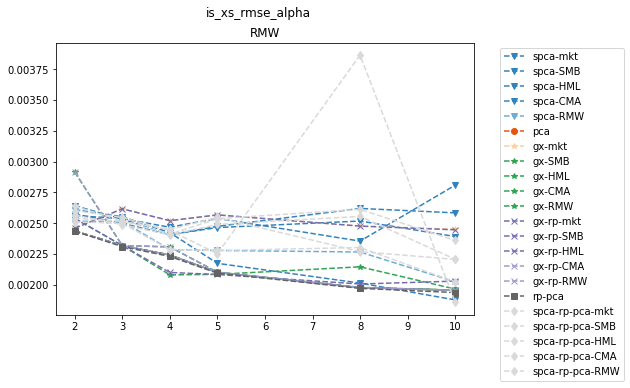

oos_xs_rmse_alpha


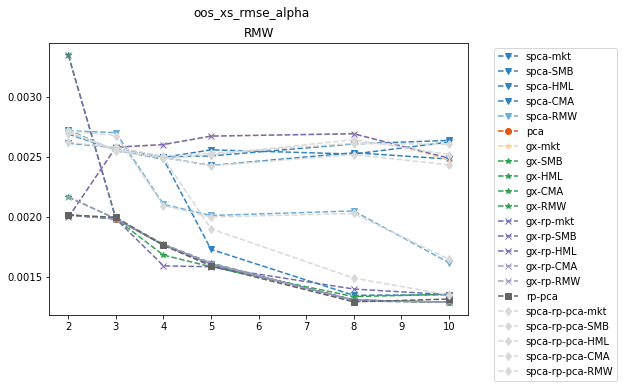

is_test_asset_ev


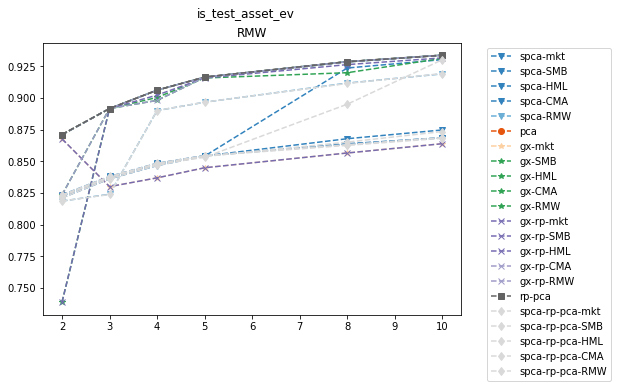

oos_test_asset_ev


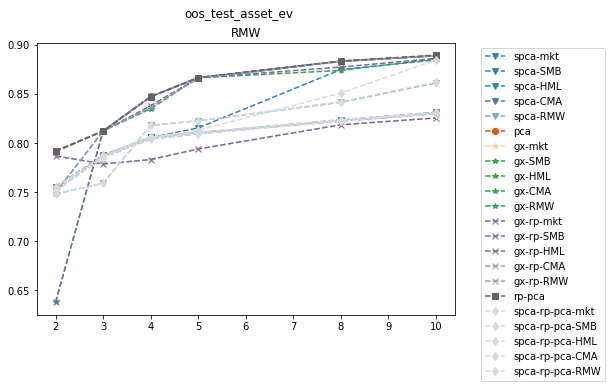

is_sharpe


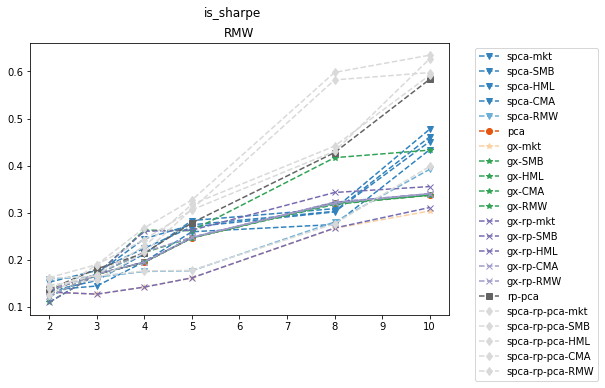

oos_sharpe


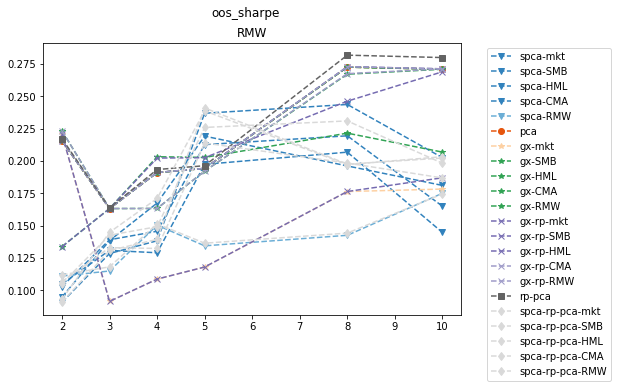

In [309]:
agg_metrics = ['is_xs_rmse_alpha', 'oos_xs_rmse_alpha', 'is_test_asset_ev', 'oos_test_asset_ev',
                  "is_sharpe", "oos_sharpe"]
for m in agg_metrics:
    print(m)
    plot_metric_across_tgt_factors(dec_results, names, metrics, m, 
             tgt_factors, [2, 3, 4, 5, 8, 10])

is_xs_rmse_alpha


oos_xs_rmse_alpha


is_test_asset_ev


oos_test_asset_ev


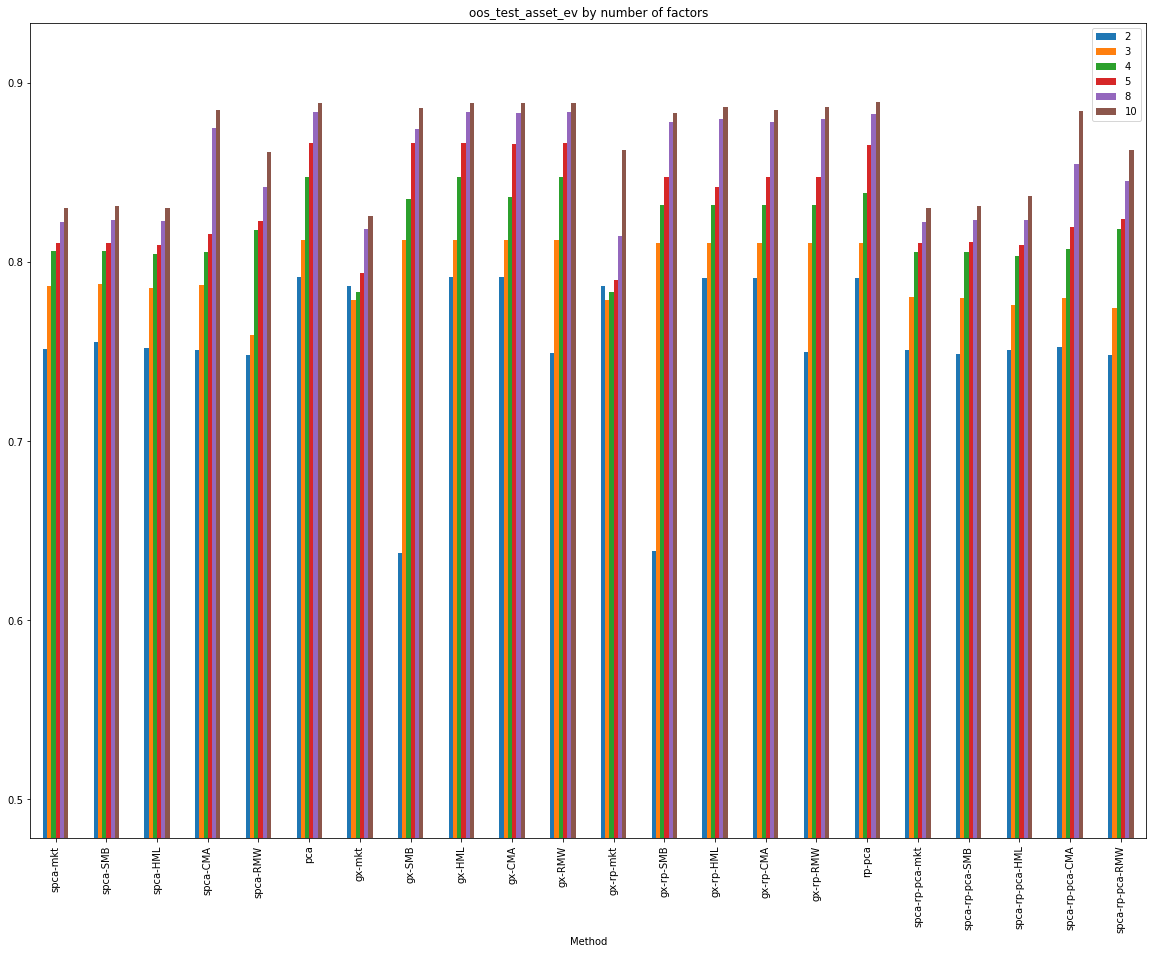

is_sharpe


oos_sharpe


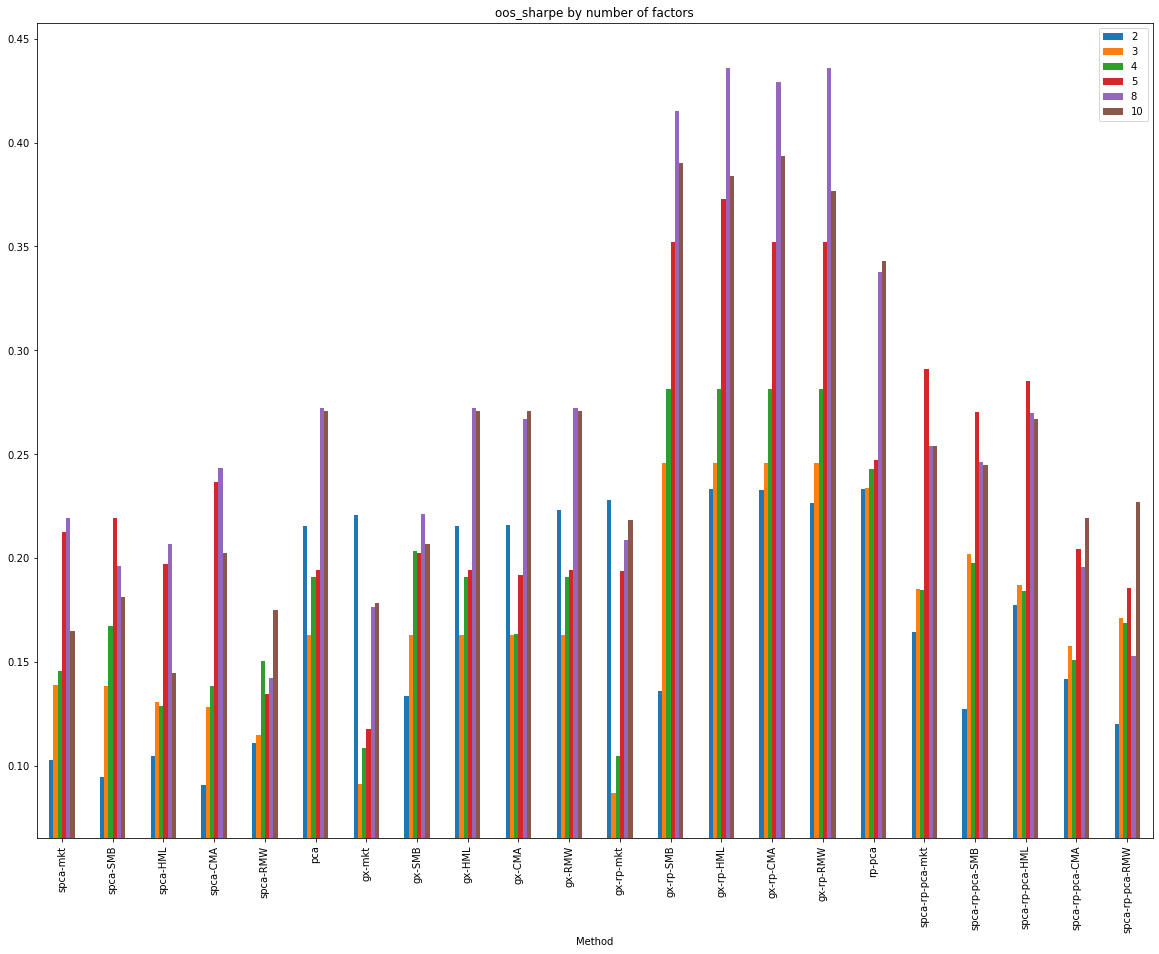

In [365]:
agg_metrics = ['is_xs_rmse_alpha', 'oos_xs_rmse_alpha', 'is_test_asset_ev', 'oos_test_asset_ev',
                  "is_sharpe", "oos_sharpe"]
for m in agg_metrics:
    print(m)
    plot_metric_across_tgt_factors_bar(dec_results, names, metrics, m, 
             tgt_factors, [2, 3, 4, 5, 8, 10])

is_r2


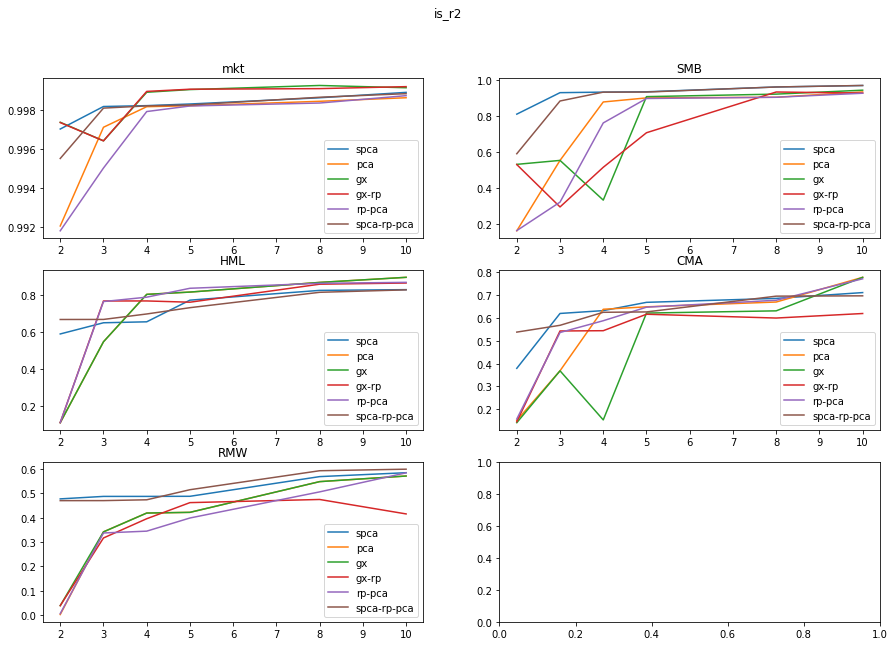

oos_r2


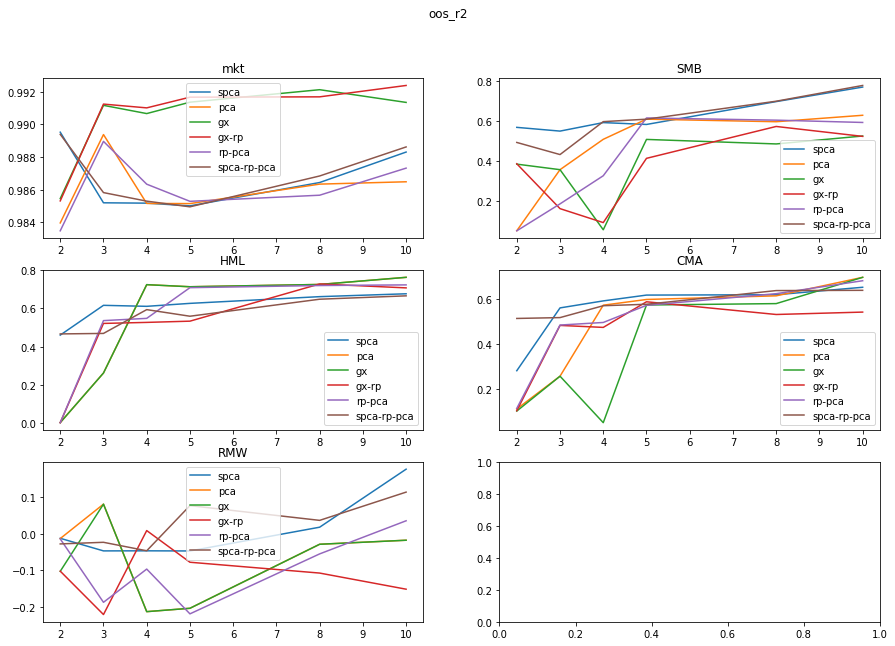

gx_is_sharpe


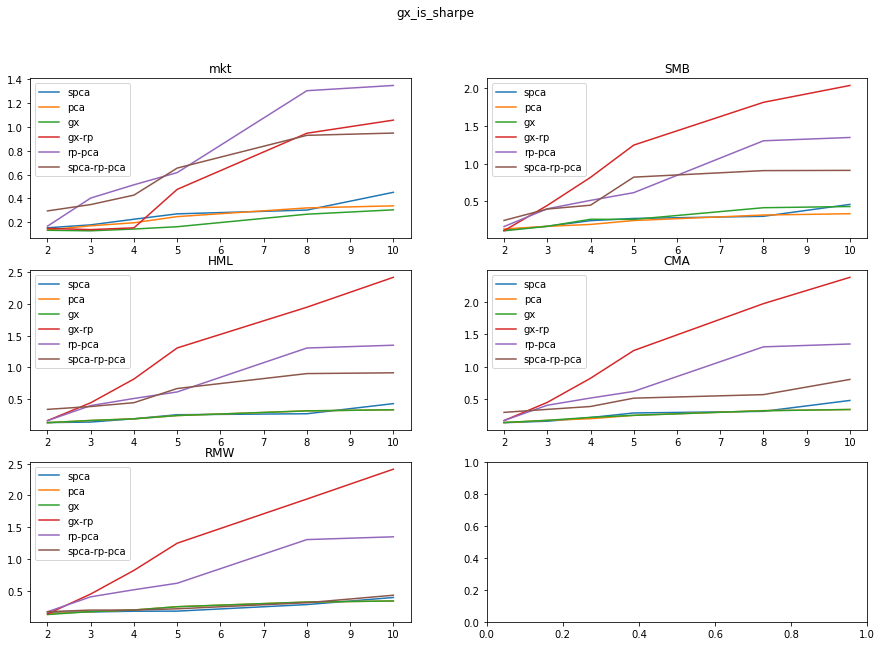

gx_oos_sharpe


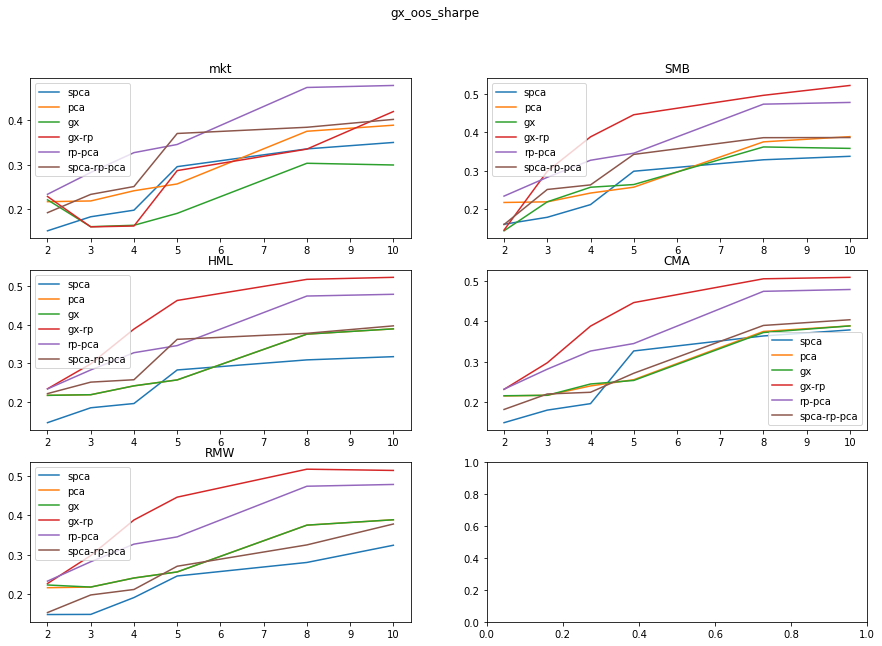

gx_oos_sharpe_true


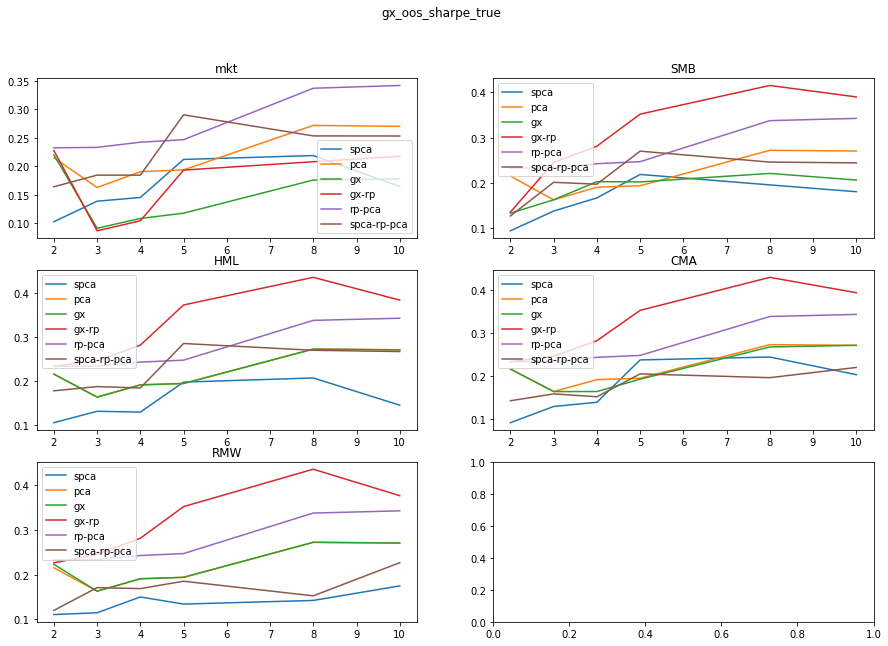

is_rpremia


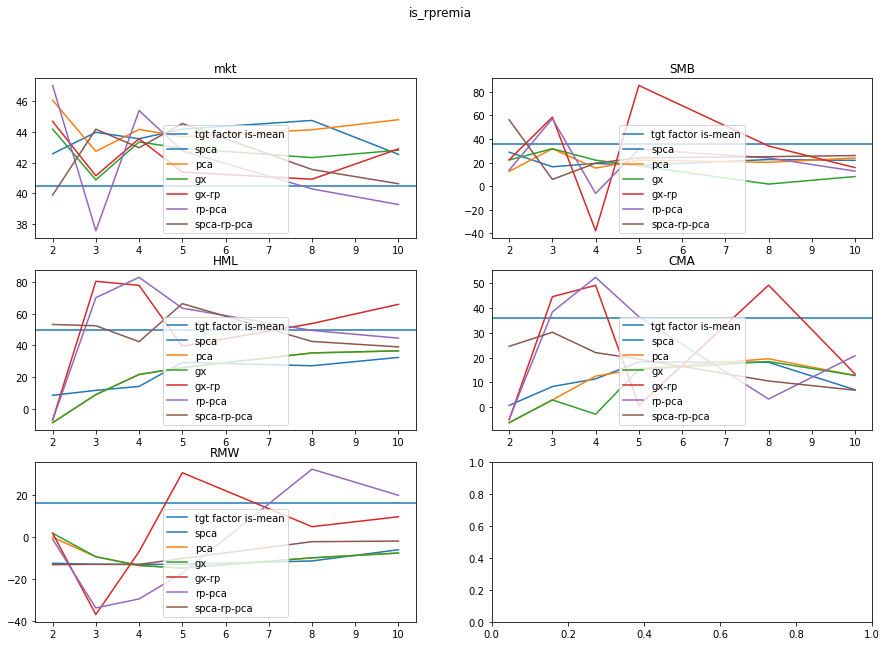

oos_rpremia


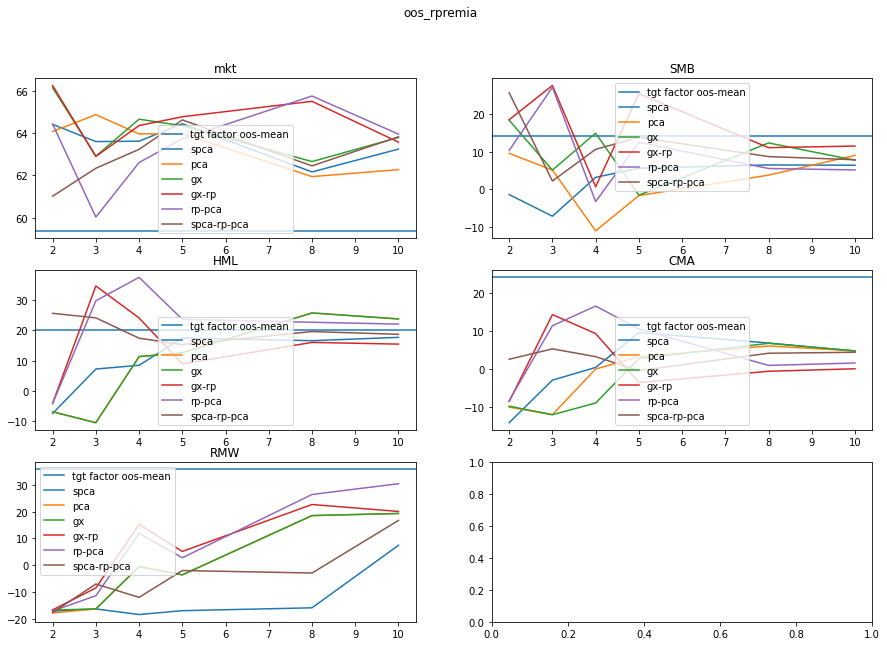

true_oos_rpremia


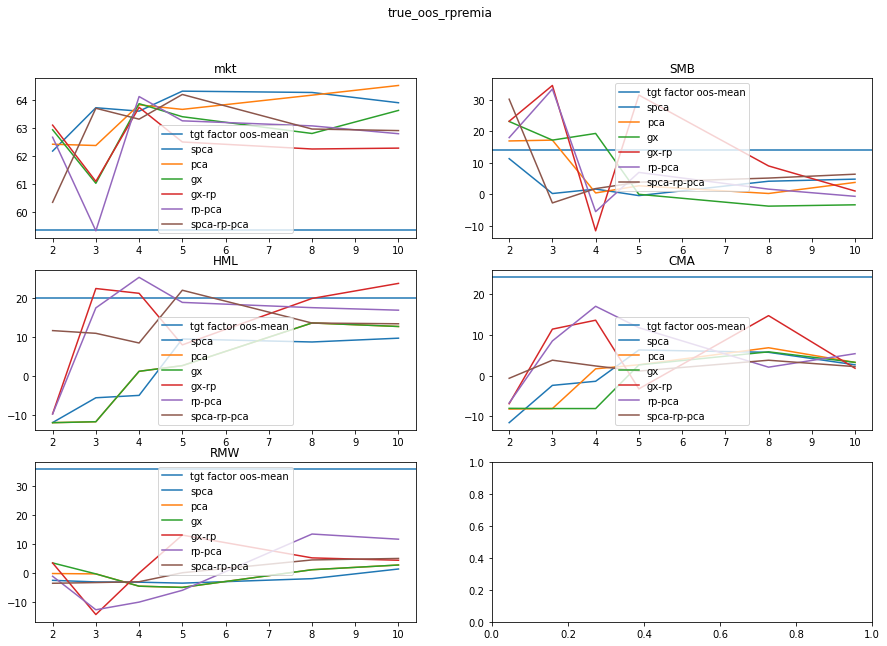

is_xs_rmse_alpha


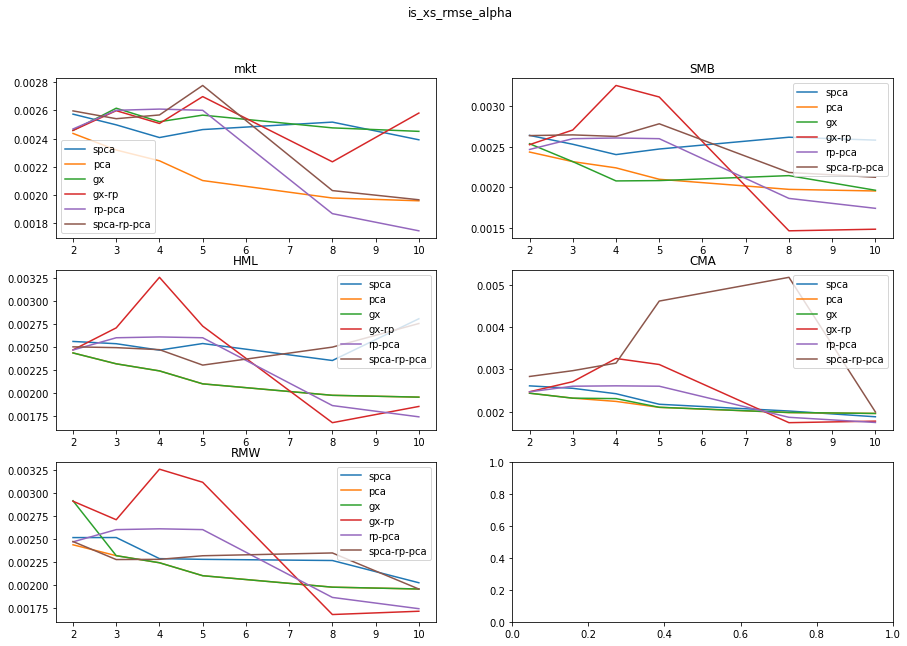

oos_xs_rmse_alpha


is_test_asset_ev


oos_test_asset_ev


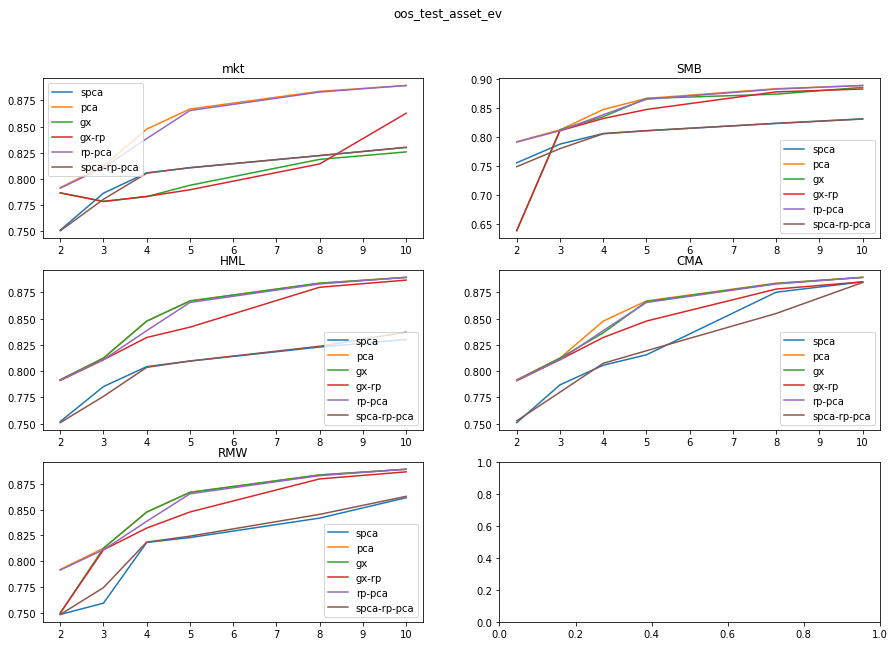

is_sharpe


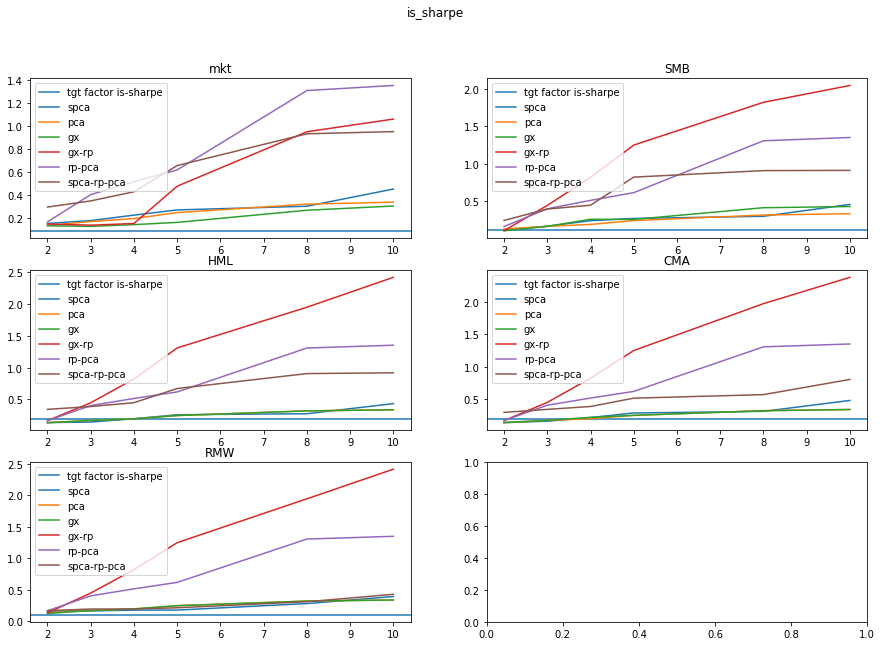

oos_sharpe


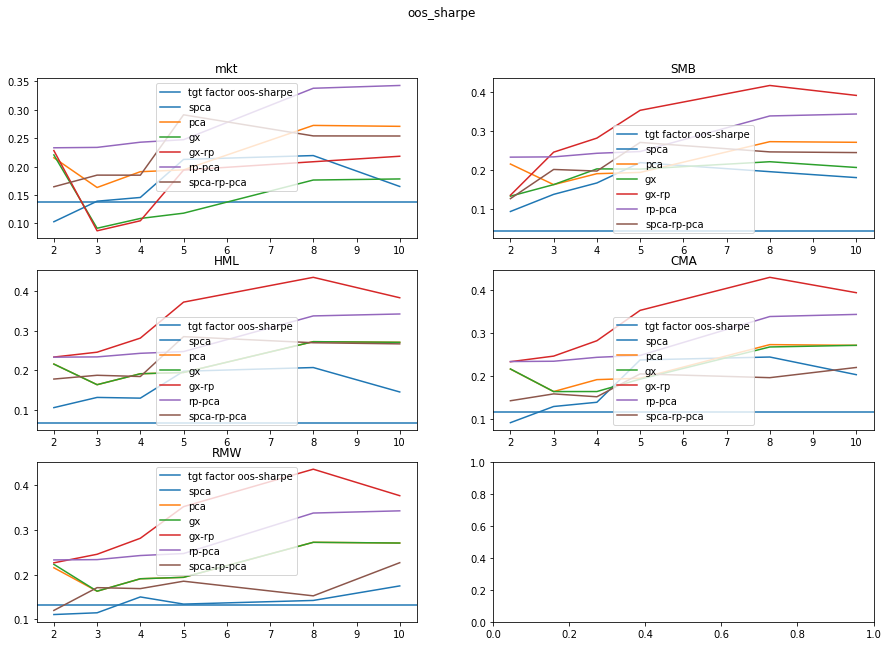

In [370]:
for m in metrics:
    print(m)
    plot_methods(dec_results, names, metrics, m, 
             tgt_factors, (2, 3, 4, 5, 8, 10))


In [ ]:
for m in metrics:
    print(m)
    plot_methods(results, names, metrics, m, 
             tgt_factors, (2, 3, 4, 5, 8, 10))

In [150]:
np.mean(chen_z_data_panel, axis=0)

array([ 7.96963299e-01,  1.17378472e+00,  1.36255233e+00,  1.44026365e+00,
        1.39307629e+00,  1.27671369e+00,  1.23537220e+00,  1.21651825e+00,
        1.44957274e+00,  1.70130225e+00,  1.19199368e+00,  1.27489978e+00,
        1.32641973e+00,  1.36551320e+00,  1.35007375e+00,  1.23031411e+00,
        1.30481096e+00,  1.28418439e+00,  1.26701221e+00,  1.42222848e+00,
        1.17802852e+00,  1.30562765e+00,  1.36331908e+00,  1.29733398e+00,
        1.30867653e+00,  1.94332244e+00,  7.56315298e-02,  9.41040982e-01,
        1.20513716e+00,  1.35800880e+00,  1.35400005e+00,  1.48854554e+00,
        1.43095327e+00,  1.11827768e+00,  1.14892773e+00,  1.42090004e+00,
        1.76048310e+00,  6.66961497e-01,  1.04670458e+00,  1.17147817e+00,
        1.35461750e+00,  1.81459814e+00,  7.67335109e-01,  1.22225734e+00,
        1.34608052e+00,  1.45963147e+00,  1.65340184e+00,  7.80967872e-01,
        1.11143639e+00,  1.25556962e+00,  1.37324790e+00,  1.63672122e+00,
        8.62884013e-01,  

In [117]:
np.argwhere(np.isnan(dec_port_panel))

array([[486, 100],
       [486, 101],
       [486, 102],
       [486, 103],
       [486, 104],
       [486, 105],
       [486, 106],
       [486, 107],
       [486, 108],
       [486, 109],
       [486, 120],
       [486, 121],
       [486, 122],
       [486, 123],
       [486, 124],
       [486, 125],
       [486, 126],
       [486, 127],
       [486, 128],
       [486, 129],
       [486, 150],
       [486, 151],
       [486, 152],
       [486, 153],
       [486, 154],
       [486, 155],
       [486, 156],
       [486, 157],
       [486, 158],
       [486, 159],
       [487, 100],
       [487, 101],
       [487, 102],
       [487, 103],
       [487, 104],
       [487, 105],
       [487, 106],
       [487, 107],
       [487, 108],
       [487, 109],
       [487, 120],
       [487, 121],
       [487, 122],
       [487, 123],
       [487, 124],
       [487, 125],
       [487, 126],
       [487, 127],
       [487, 128],
       [487, 129],
       [487, 150],
       [487, 151],
       [487,

In [45]:
np.array(results).shape

/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(1, 3, 6, 14)

In [46]:
len(names)

6

In [47]:
len(metrics)

12

is_xs_rmse_alpha


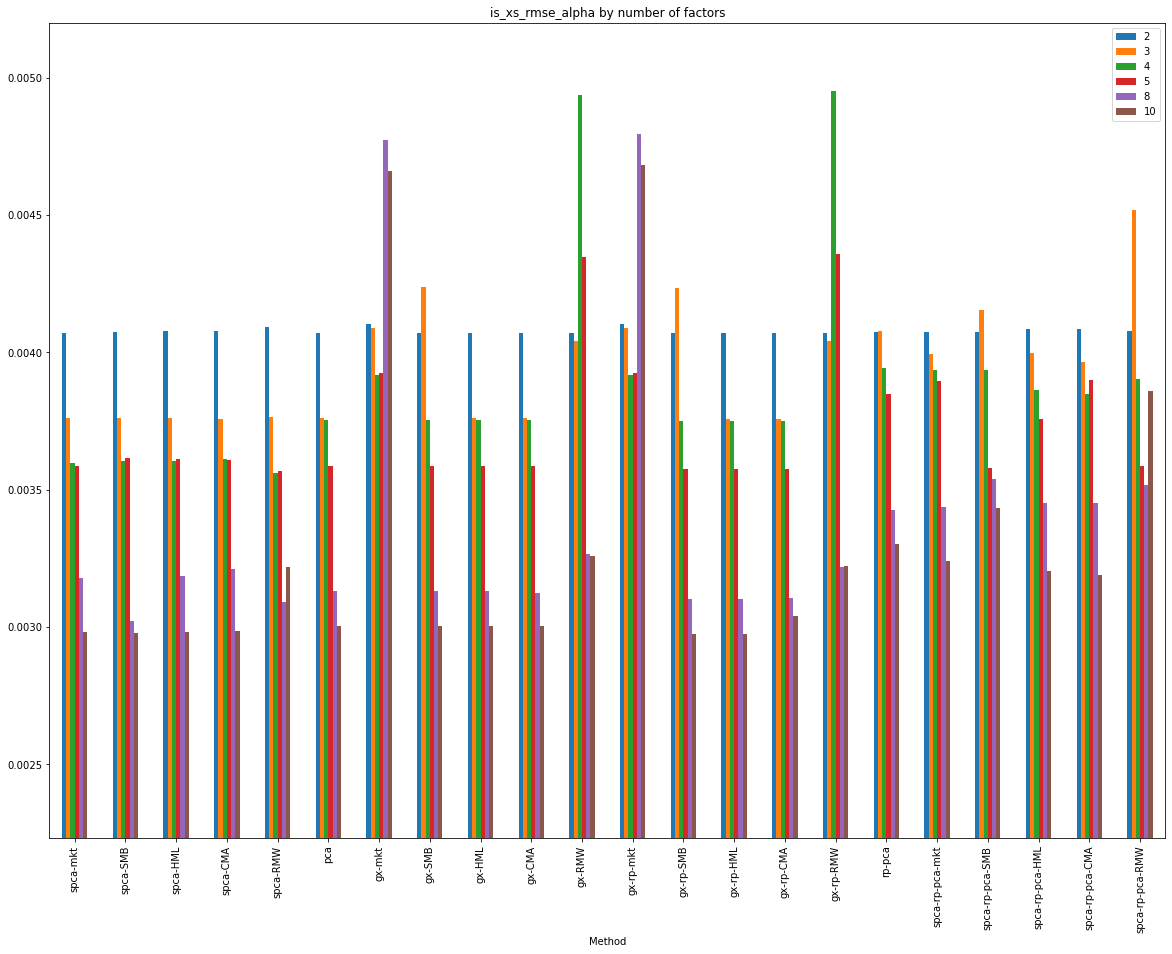

oos_xs_rmse_alpha


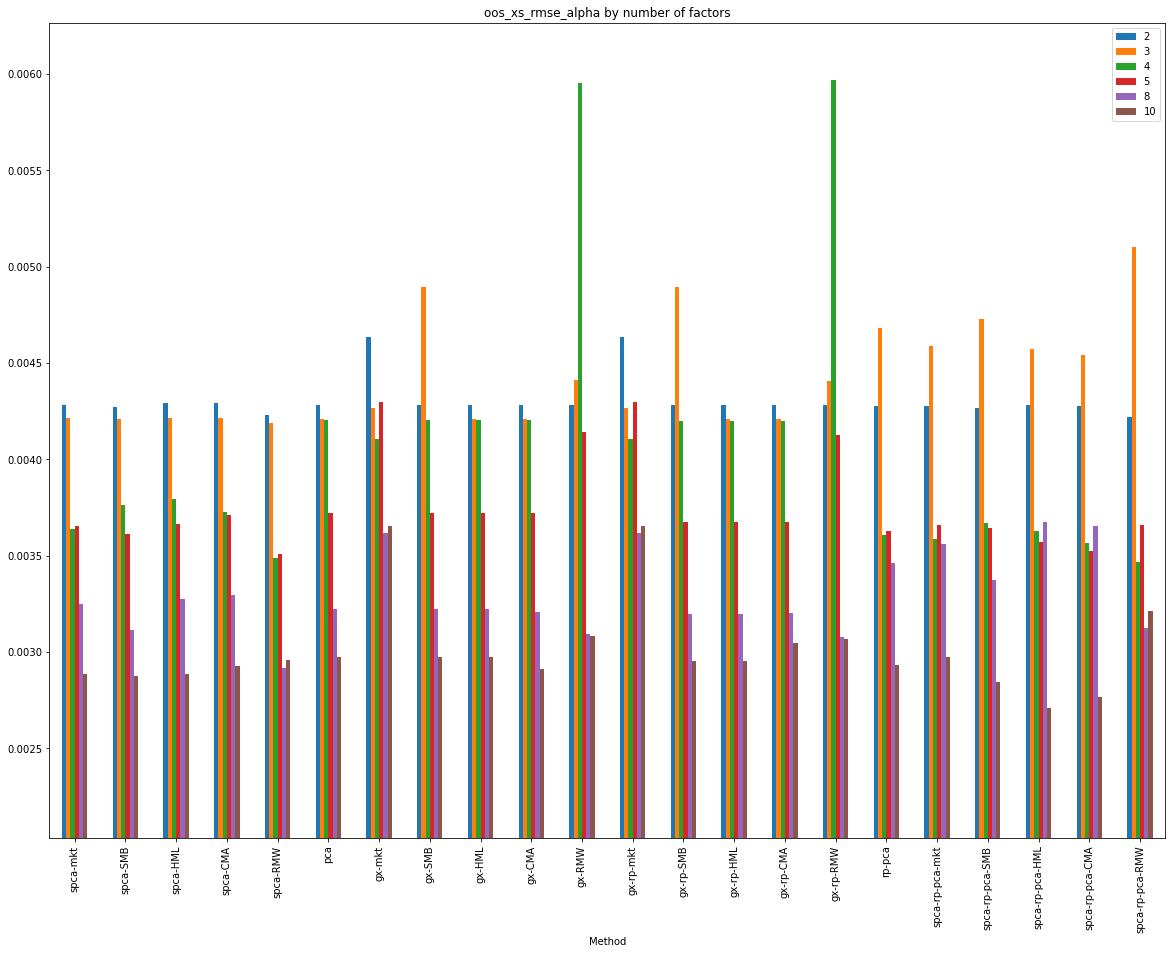

is_test_asset_ev


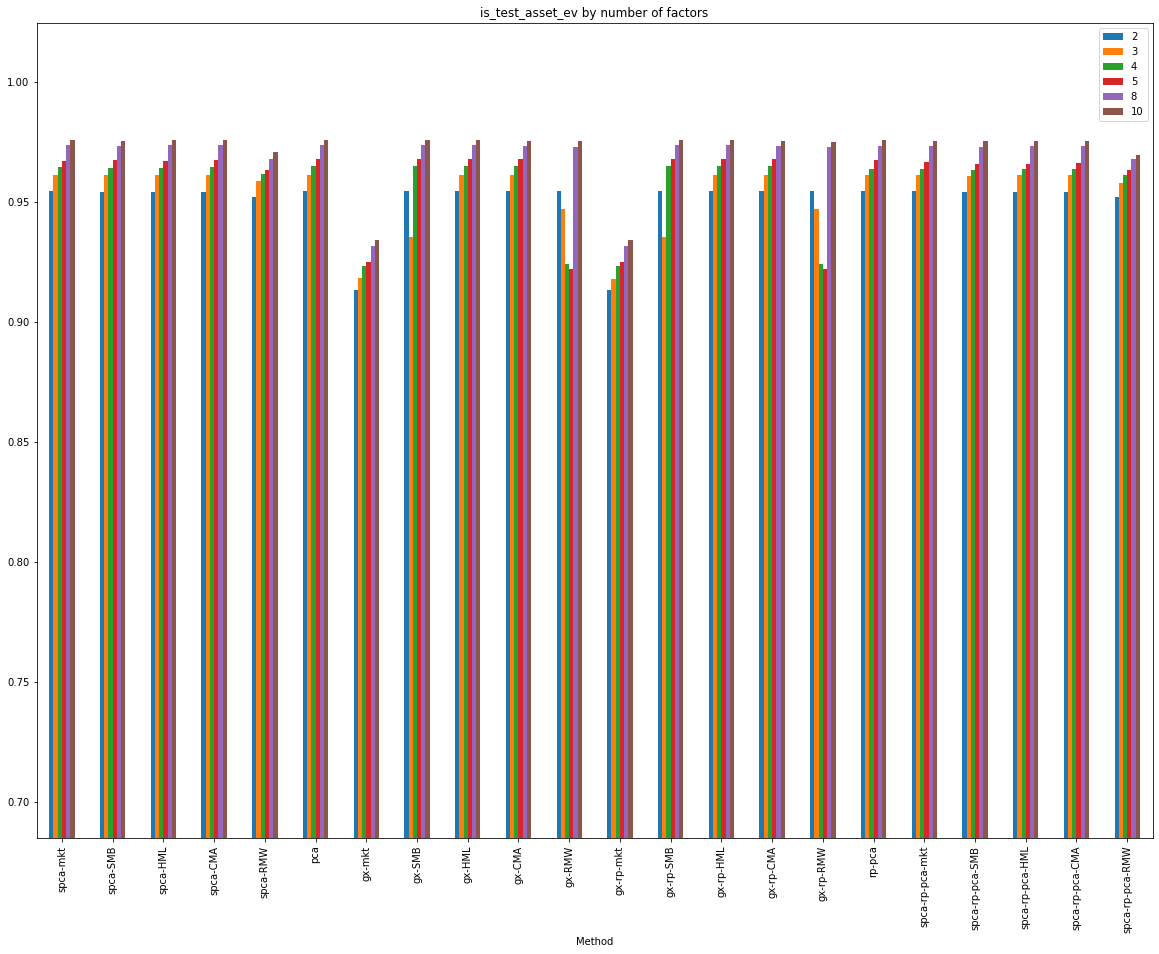

oos_test_asset_ev


is_sharpe


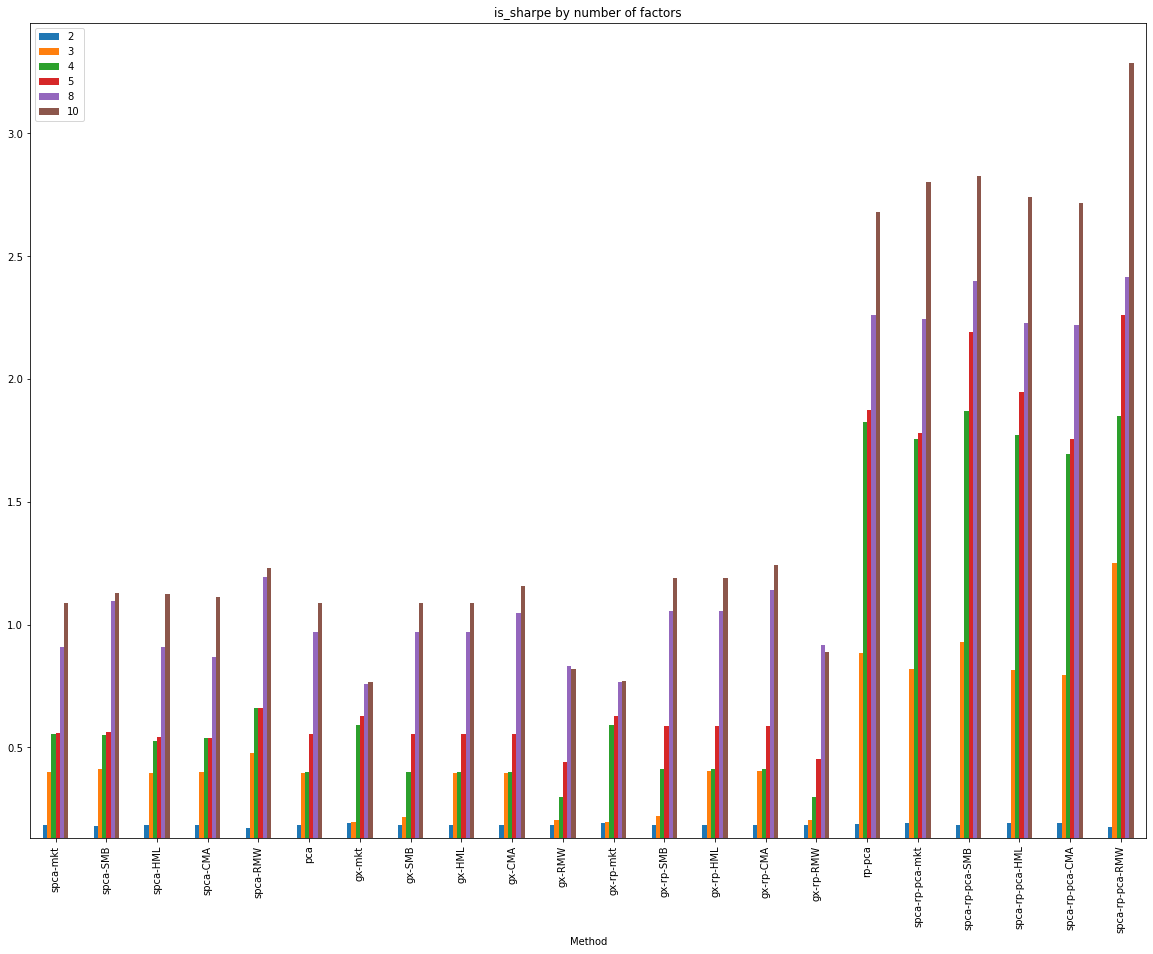

oos_sharpe


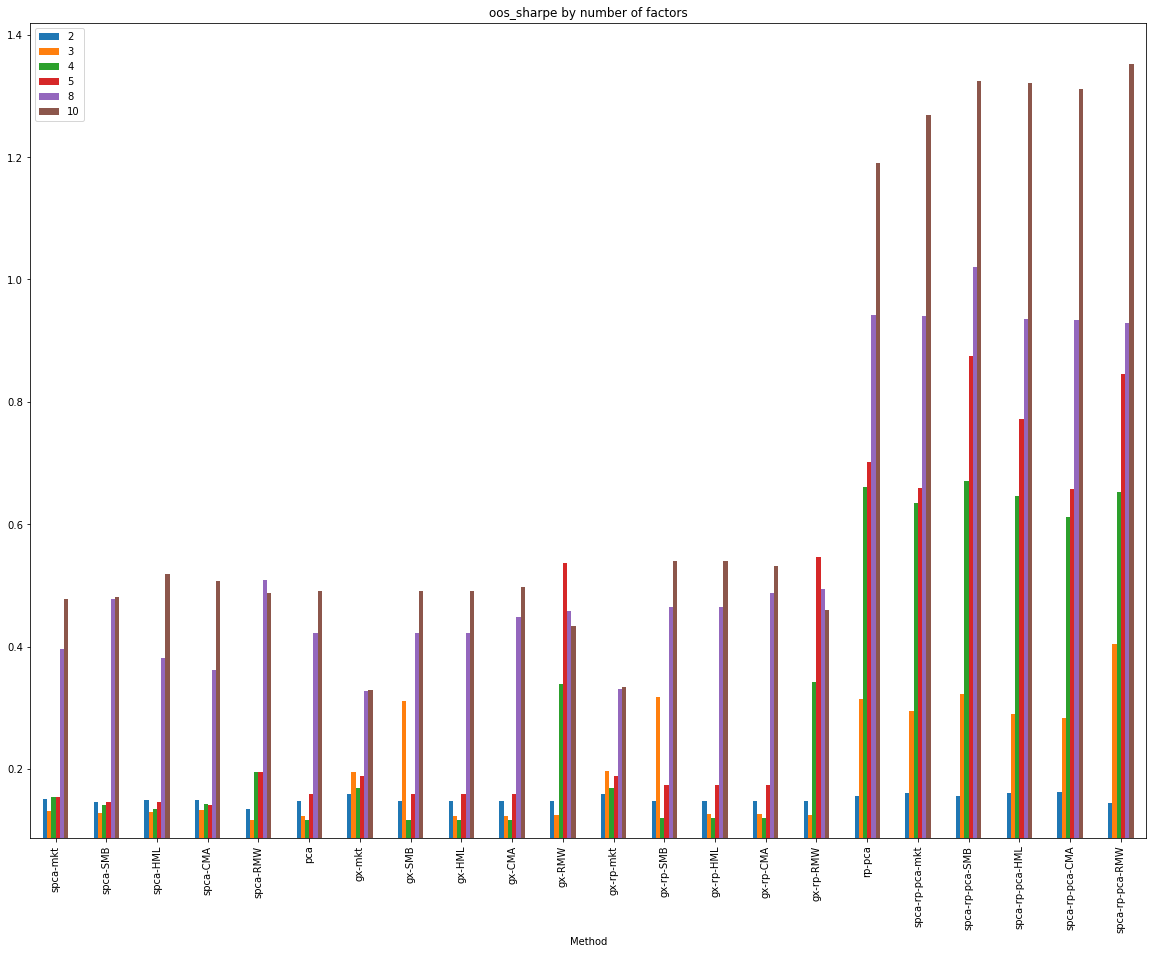

In [251]:
agg_metrics = ['is_xs_rmse_alpha', 'oos_xs_rmse_alpha', 'is_test_asset_ev', 'oos_test_asset_ev',
                  "is_sharpe", "oos_sharpe"]
for m in agg_metrics:
    print(m)
    plot_metric_across_tgt_factors_bar(results, names, metrics, m, 
             tgt_factors, [2, 3, 4, 5, 8, 10])

is_r2


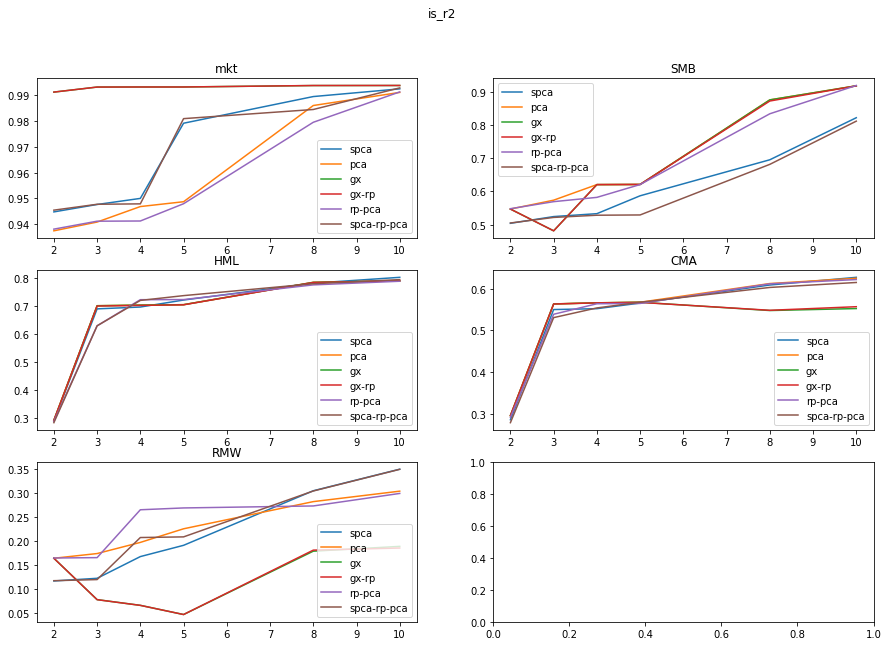

oos_r2


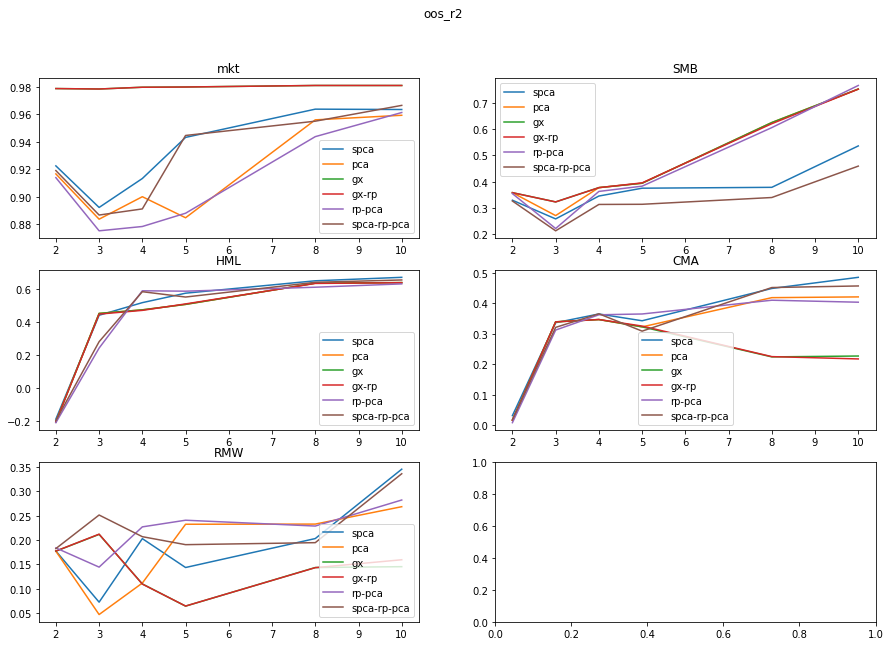

gx_is_sharpe


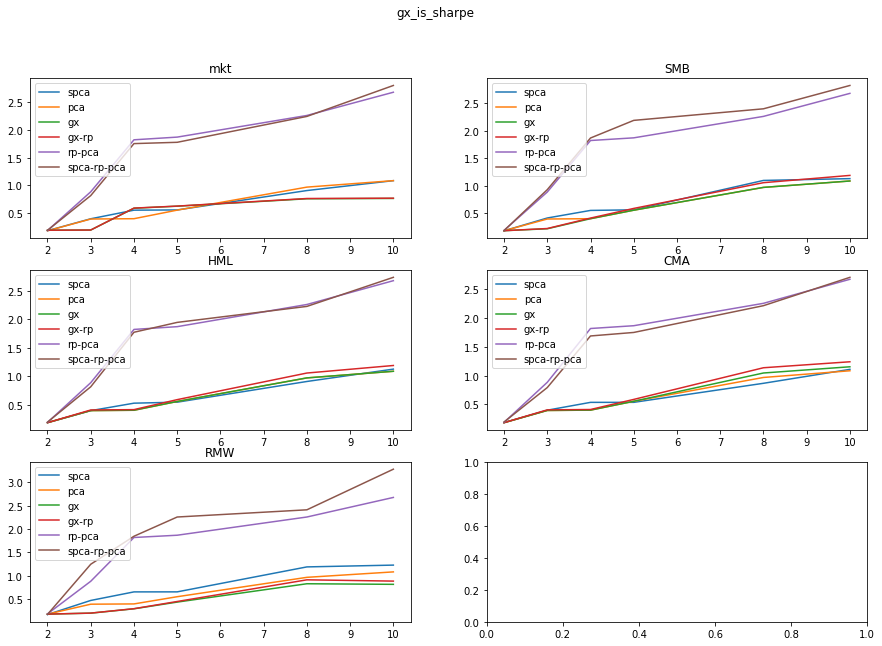

gx_oos_sharpe


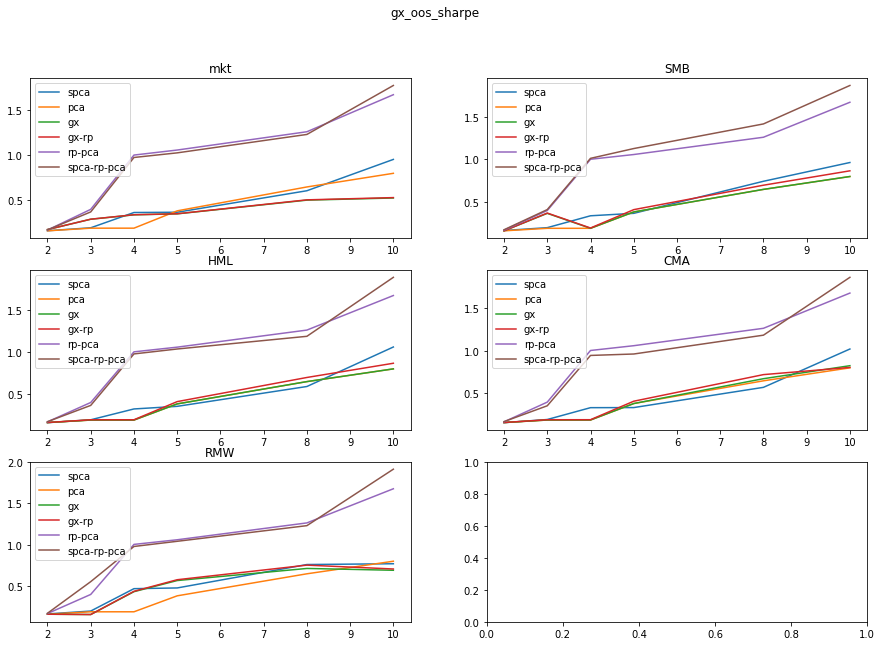

gx_oos_sharpe_true


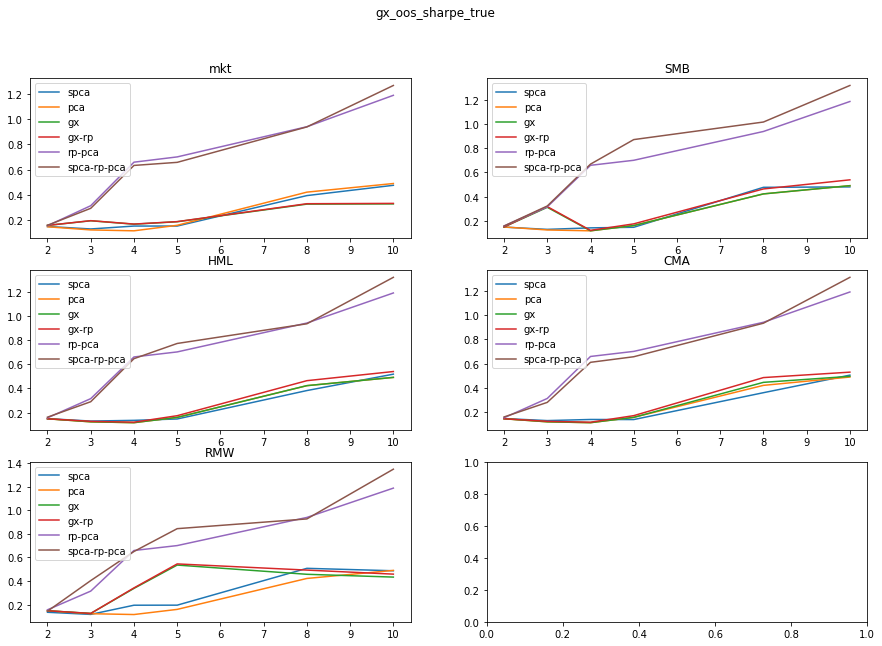

is_rpremia


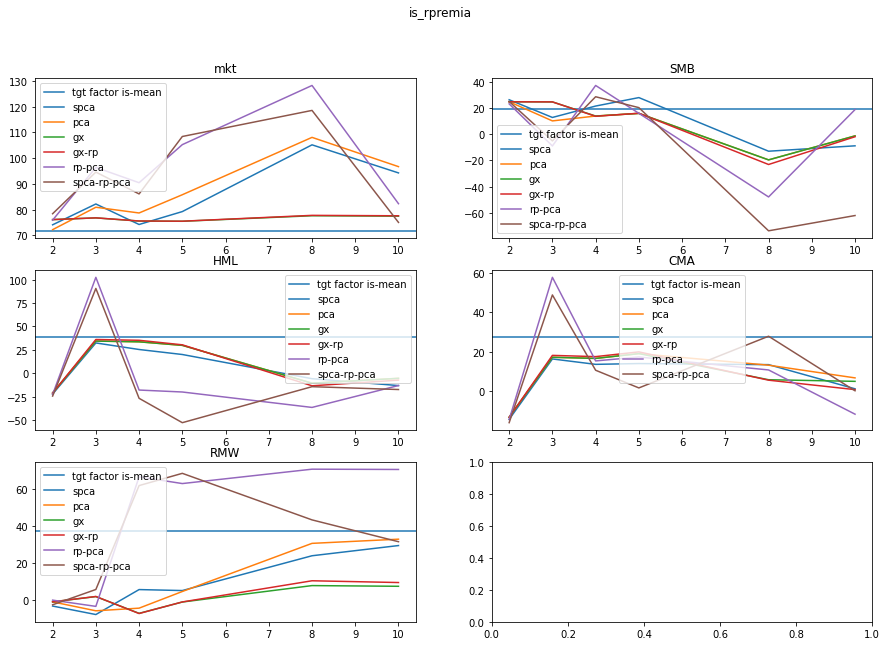

oos_rpremia


true_oos_rpremia


is_xs_rmse_alpha


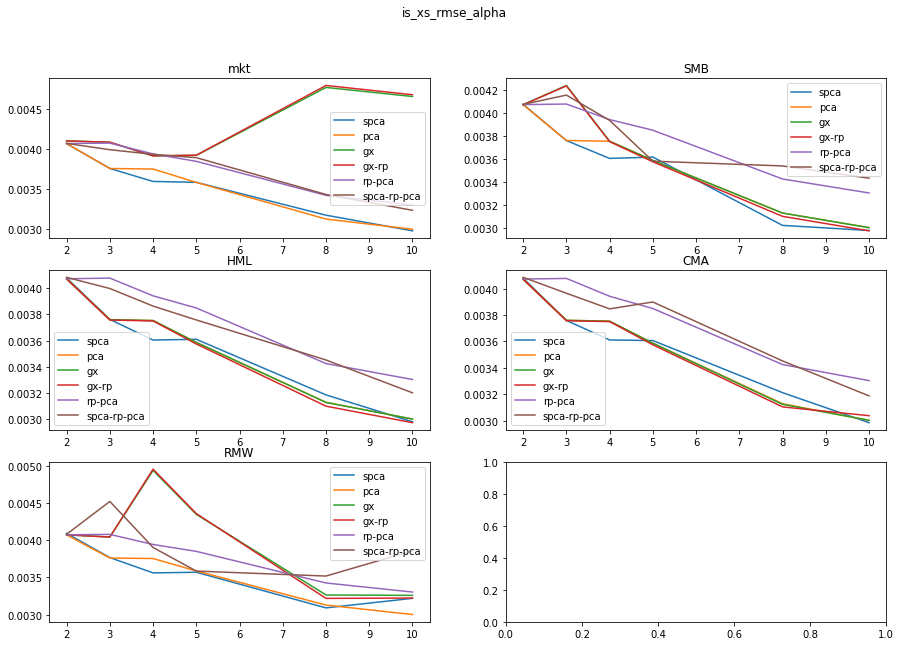

oos_xs_rmse_alpha


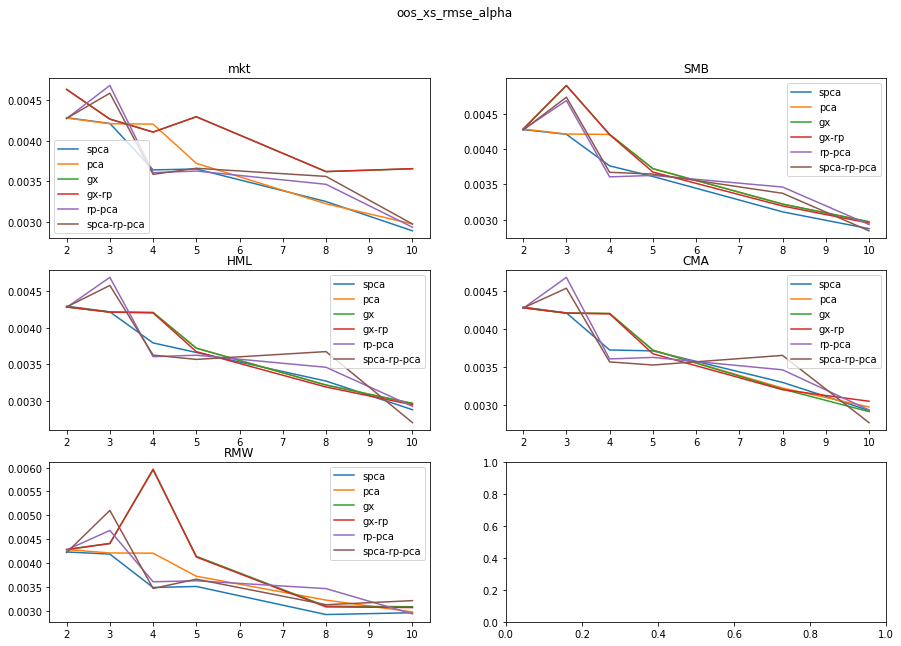

is_test_asset_ev


oos_test_asset_ev


is_sharpe


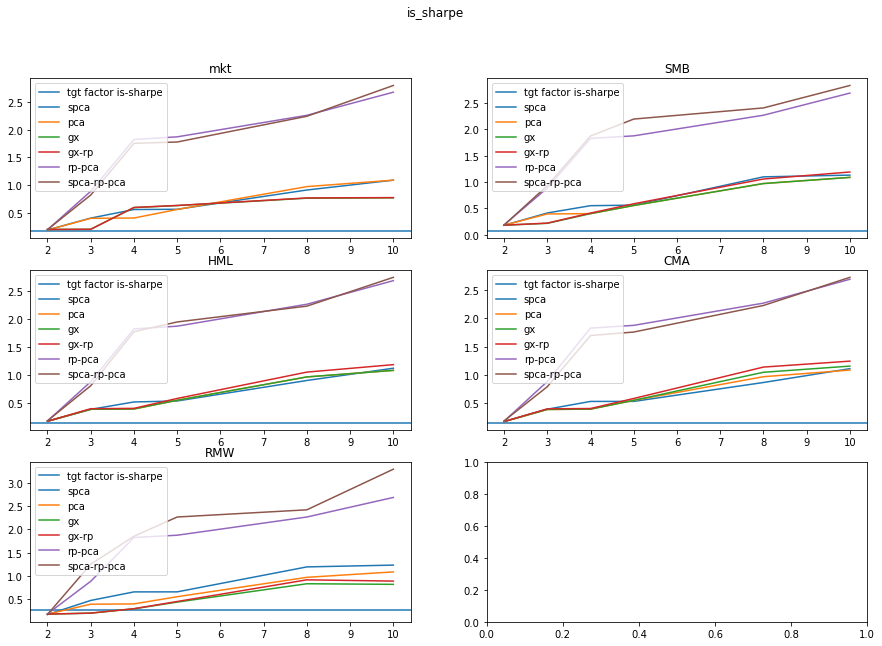

oos_sharpe


In [222]:
for m in metrics:
    print(m)
    plot_methods(results, names, metrics, m, 
             tgt_factors, (2, 3, 4, 5, 8, 10))


In [16]:
from tqdm.notebook import tqdm

In [117]:
chen_z_data_panel.shape

(522, 772)

In [316]:
dec_port_panel.shape

(630, 370)

In [315]:
np.savetxt("kns.csv", dec_port_panel, delimiter=",")

In [119]:
np.savetxt("chenz.csv", chen_z_data_panel, delimiter=",")

In [132]:
np.array(results)[0,:,-2,5]

/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


array([75.88476687239728, 96.35803868053674, 90.42264873511631,
       105.21047317660495, 128.19409571235818, 82.27229292310209],
      dtype=object)

In [180]:
chen_z_data_panel, tgt_factor, weak_test_start = ChenZData(tgt_factor="mkt").data

In [184]:
np.mean(tgt_factor[:261]) * bp_normalization , np.mean(tgt_factor) / np.std(tgt_factor)

(71.73563218390805, 0.14522557660861452)

In [185]:
tgt_factor.shape

(522,)

rp_pca_term 10 (370, 370)
(370, 5)
sharpe ratio 0.2788348411952586


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

(0.4170375996466902,
 -0.20894919685974345,
 0.2783918943846988,
 0.26429907018380044,
 0.19594844269845813,
 -16.26728069575775,
 -3.192016194146282,
 -5.684135158321587,
 0.0020941497339014587,
 0.0015897158643424613,
 0.9164814730755123,
 0.8667366213603851,
 0.2788348411952586,
 0.1779693555645307,
 array([-3.40749254e-20, -9.46525706e-22, -2.66210355e-22, -3.12595492e-22,
        -1.10248733e-22]),
 array([ 6.51518883e-05,  2.34181695e-06, -8.32818254e-07,  3.21786633e-08,
        -3.15083826e-07]))

In [219]:
results = []
names = ["spca", "pca", "gx", "gx-rp", "rp-pca", "spca-rp-pca"]

for tgt in  tqdm(tgt_factors):
    results.append([])
    print(tgt)
    chen_z_data_panel, tgt_factor, weak_test_start = ChenZData(tgt_factor=tgt).data
    for k in (2, 3, 4, 5, 8, 10):
        results[-1].append([])
        spca = SPCA(chen_z_data_panel, tgt_factor, weak_test_start, N_factor=k)

        res = spca.fit(1, true_oos=True, stack_lags=False, fit_factors_epanding_window=False, print_res=False)
        results[-1][-1].append(res)

        res = spca.fit(1, true_oos=True, stack_lags=False, fit_factors_epanding_window=False,
                pca=True, print_res=False)
        results[-1][-1].append(res)
        spca = GX_SPCA(chen_z_data_panel, tgt_factor, weak_test_start, N_factors=k)
        res = spca.fit(1, true_oos=True, stack_lags=False, fit_factors_epanding_window=False, print_res=False)
        results[-1][-1].append(res)
        res = spca.fit(1, true_oos=True, stack_lags=False, fit_factors_epanding_window=False, print_res=False,
                rp_pca_term=10)
        results[-1][-1].append(res)
        spca = RP_PCA(chen_z_data_panel, tgt_factor, weak_test_start, N_factors=k)
        res = spca.fit(1, true_oos=True, stack_lags=False, fit_factors_epanding_window=False, print_res=False,
                      rp_pca_term=10)
        results[-1][-1].append(res)
        spca = SPCA(chen_z_data_panel, tgt_factor, weak_test_start, N_factor=k)

        res = spca.fit(1, true_oos=True, stack_lags=False, fit_factors_epanding_window=False, print_res=False,
                      rp_pca=10)
        results[-1][-1].append(res)
#         print_table(metrics, names, results[-1])
        print()

  0%|          | 0/5 [00:00<?, ?it/s]

mkt
chosen quantile: 0.98
0 [76.09257845] [51.91854338]
chosen quantile: 0.98
10 [76.09419895] [51.91988414]
rp_pca_term 10 (772, 772)
(772, 2)
sharpe ratio 0.18747130400622622



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.98
0 [76.75598796] [57.85568624]
chosen quantile: 0.98
10 [76.77004795] [57.97658942]
rp_pca_term 10 (772, 772)
(772, 3)
sharpe ratio 0.8856673672538186



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.98
0 [75.52300136] [65.36377729]
chosen quantile: 0.98
10 [75.55023205] [65.38126125]
rp_pca_term 10 (772, 772)
(772, 4)
sharpe ratio 1.823129079046717


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 


chosen quantile: 0.98
0 [75.44128055] [58.59939233]
chosen quantile: 0.98
10 [75.46945238] [58.65329016]
rp_pca_term 10 (772, 772)
(772, 5)
sharpe ratio 1.8717715784293525



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.98
0 [77.59170695] [58.57316366]
chosen quantile: 0.98
10 [77.73909057] [58.64101758]
rp_pca_term 10 (772, 772)
(772, 8)
sharpe ratio 2.261937166688775



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.98
0 [77.42537488] [60.71087414]
chosen quantile: 0.98
10 [77.5731025] [60.70530823]
rp_pca_term 10 (772, 772)
(772, 10)
sharpe ratio 2.6808125862109917

SMB


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [25.08933397] [19.75197633]
chosen quantile: 0.0
10 [25.04974568] [19.73306724]
rp_pca_term 10 (772, 772)
(772, 2)
sharpe ratio 0.18747130400622625



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.96
0 [24.96299711] [44.82305611]
chosen quantile: 0.96
10 [24.96400382] [44.97651812]
rp_pca_term 10 (772, 772)
(772, 3)
sharpe ratio 0.8856673672538203



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [14.11981049] [91.40242378]
chosen quantile: 0.0
10 [13.90928569] [92.565093]
rp_pca_term 10 (772, 772)
(772, 4)
sharpe ratio 1.8231290790467398



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [16.12902028] [89.56043026]
chosen quantile: 0.0
10 [16.27733373] [90.57448422]
rp_pca_term 10 (772, 772)
(772, 5)
sharpe ratio 1.8717715784293463



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [-19.56216748] [111.81979046]
chosen quantile: 0.0
10 [-23.09957771] [114.01733305]
rp_pca_term 10 (772, 772)
(772, 8)
sharpe ratio 2.2619371666887718



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [-1.12786149] [78.19679598]
chosen quantile: 0.0
10 [-1.78275787] [76.55805944]
rp_pca_term 10 (772, 772)
(772, 10)
sharpe ratio 2.680812586210982

HML


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [-21.16087555] [18.20769265]
chosen quantile: 0.0
10 [-21.20359635] [18.36337918]
rp_pca_term 10 (772, 772)
(772, 2)
sharpe ratio 0.18747130400622614



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [34.35767616] [19.3596261]
chosen quantile: 0.0
10 [36.06344578] [19.53464936]
rp_pca_term 10 (772, 772)
(772, 3)
sharpe ratio 0.8856673672538186



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [33.58494688] [22.14510445]
chosen quantile: 0.0
10 [35.21166967] [22.08185473]
rp_pca_term 10 (772, 772)
(772, 4)
sharpe ratio 1.8231290790467185



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [29.7946825] [7.90339284]
chosen quantile: 0.0
10 [30.36864496] [7.67562663]
rp_pca_term 10 (772, 772)
(772, 5)
sharpe ratio 1.8717715784293536



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [-10.67600775] [15.79997163]
chosen quantile: 0.0
10 [-13.48088307] [16.10252804]
rp_pca_term 10 (772, 772)
(772, 8)
sharpe ratio 2.261937166688771


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 


chosen quantile: 0.0
0 [-5.47295149] [15.84050328]
chosen quantile: 0.0
10 [-7.41275039] [16.27287318]
rp_pca_term 10 (772, 772)
(772, 10)
sharpe ratio 2.680812586211001


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 


CMA
chosen quantile: 0.0
0 [-13.35270963] [0.52581001]
chosen quantile: 0.0
10 [-13.38469639] [0.58390692]
rp_pca_term 10 (772, 772)
(772, 2)
sharpe ratio 0.1874713040062263


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 


chosen quantile: 0.0
0 [17.11718594] [1.42409248]
chosen quantile: 0.0
10 [18.07960628] [1.49743507]
rp_pca_term 10 (772, 772)
(772, 3)
sharpe ratio 0.8856673672538199



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [16.535007] [29.17735442]
chosen quantile: 0.0
10 [17.44714112] [29.6130102]
rp_pca_term 10 (772, 772)
(772, 4)
sharpe ratio 1.823129079046713



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [18.97082615] [19.23391414]
chosen quantile: 0.0
10 [19.85205328] [19.5229216]
rp_pca_term 10 (772, 772)
(772, 5)
sharpe ratio 1.8717715784293885



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.22
0 [5.700829] [29.96993646]
chosen quantile: 0.22
10 [5.47194462] [35.14939844]
rp_pca_term 10 (772, 772)
(772, 8)
sharpe ratio 2.2619371666887713



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.2
0 [4.87485626] [28.28601624]
chosen quantile: 0.24
10 [0.66792103] [11.24281094]
rp_pca_term 10 (772, 772)
(772, 10)
sharpe ratio 2.6808125862109864

RMW


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.0
0 [-0.98554574] [-6.75028105]
chosen quantile: 0.0
10 [-0.96175757] [-6.63671198]
rp_pca_term 10 (772, 772)
(772, 2)
sharpe ratio 0.18747130400622614



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.64
0 [1.86069552] [0.94109357]
chosen quantile: 0.64
10 [1.92563326] [5.68169837]
rp_pca_term 10 (772, 772)
(772, 3)
sharpe ratio 0.8856673672538208



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.92
0 [-7.16865015] [3.43656422]
chosen quantile: 0.92
10 [-7.27567149] [3.55883238]
rp_pca_term 10 (772, 772)
(772, 4)
sharpe ratio 1.823129079046735



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.9400000000000001
0 [-1.06828927] [-2.60662431]
chosen quantile: 0.9400000000000001
10 [-1.02766933] [-3.31496937]
rp_pca_term 10 (772, 772)
(772, 5)
sharpe ratio 1.871771578429368



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.32
0 [7.79293178] [-5.8687205]
chosen quantile: 0.32
10 [10.39279416] [-5.75726438]
rp_pca_term 10 (772, 772)
(772, 8)
sharpe ratio 2.2619371666887704



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

chosen quantile: 0.36
0 [7.41646298] [-10.46730863]
chosen quantile: 0.42
10 [9.44157157] [-18.72777906]
rp_pca_term 10 (772, 772)
(772, 10)
sharpe ratio 2.6808125862110024



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future 

In [63]:
np.mean(tgt_factor[:522//2]), np.mean(tgt_factor[522//2:]), np.mean(tgt_factor)

(0.0071735632183908046, 0.005491954022988505, 0.006332758620689655)

In [57]:
tgt_factor.shape

(522,)

In [66]:
np.mean(chen_z_data_panel[:,:10], axis=0)

array([0.8006315 , 1.17745292, 1.36622053, 1.44393185, 1.39674449,
       1.28038189, 1.23904039, 1.22018645, 1.45324094, 1.70497045])

In [69]:
np.linalg.eigh(chen_z_data_panel@chen_z_data_panel.T)[0][::-1] / np.sum(np.linalg.eigh(chen_z_data_panel@chen_z_data_panel.T)[0][::-1])

array([9.16001832e-01, 2.18743314e-02, 1.35726376e-02, 7.36041139e-03,
       3.17929389e-03, 2.75903111e-03, 2.25624050e-03, 1.91585020e-03,
       1.75060526e-03, 1.41461957e-03, 1.18217443e-03, 1.00536652e-03,
       8.91279227e-04, 8.45647633e-04, 7.65023738e-04, 6.57900245e-04,
       6.36122128e-04, 6.11948279e-04, 5.79279375e-04, 5.16825741e-04,
       4.87448621e-04, 4.64745854e-04, 4.58666360e-04, 4.25056061e-04,
       4.10179823e-04, 3.93541943e-04, 3.69739536e-04, 3.65358465e-04,
       3.40271805e-04, 3.39274840e-04, 3.35235358e-04, 3.14582473e-04,
       3.00340056e-04, 2.96281073e-04, 2.81113758e-04, 2.68962118e-04,
       2.66306584e-04, 2.58657354e-04, 2.53419535e-04, 2.44994774e-04,
       2.37874687e-04, 2.31413384e-04, 2.22451564e-04, 2.18763053e-04,
       2.10317568e-04, 2.07141285e-04, 1.98924482e-04, 1.89188004e-04,
       1.81252194e-04, 1.75914223e-04, 1.72355657e-04, 1.70322089e-04,
       1.62035571e-04, 1.60850565e-04, 1.60245111e-04, 1.57538236e-04,
      

  0%|          | 0/5 [00:00<?, ?it/s]

mkt
(772, 5) (261, 772) (261, 5)
(772, 5) (261, 772) (261, 5)
0 [136.85938664] [71.43674]
10 [134.40116575] [71.4429618]
rp_pca_term 10
rp pca rp estimate [0.67704738]
rp_pca_term 10
rp pca rp estimate [0.21693887]
(772, 5) (261, 772) (261, 5)

SMB


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


(772, 5) (261, 772) (261, 5)
(772, 5) (261, 772) (261, 5)
0 [24.95119937] [94.48379249]
10 [24.64577953] [95.4856832]
rp_pca_term 10
rp pca rp estimate [0.0015416]
rp_pca_term 10
rp pca rp estimate [0.43838728]
(772, 5) (261, 772) (261, 5)

HML


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


(772, 5) (261, 772) (261, 5)
(772, 5) (261, 772) (261, 5)
0 [33.49401648] [12.04470191]
10 [34.40780063] [11.81410883]
rp_pca_term 10
rp pca rp estimate [-0.09373932]
rp_pca_term 10
rp pca rp estimate [0.06824077]
(772, 5) (261, 772) (261, 5)

CMA


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


(772, 5) (261, 772) (261, 5)
(772, 5) (261, 772) (261, 5)
0 [20.3509884] [20.2518851]
10 [21.50269058] [20.54808242]
rp_pca_term 10
rp pca rp estimate [0.06759071]
rp_pca_term 10
rp pca rp estimate [0.16248867]
(772, 5) (261, 772) (261, 5)

RMW


/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


(772, 5) (261, 772) (261, 5)
(772, 5) (261, 772) (261, 5)
0 [1.45382768] [-5.26167083]
10 [1.51051158] [-5.94554122]
rp_pca_term 10
rp pca rp estimate [0.26904436]
rp_pca_term 10
rp pca rp estimate [0.04713094]
(772, 5) (261, 772) (261, 5)



/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/sven/miniconda3/envs/env-349/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [21]:
results = []

In [25]:
results

[[[(0.9751147377662446,
    0.9338590472251793,
    0.6992245541187689,
    0.3977586033414325,
    0.18269872055623906,
    0.4421185182390842,
    0.24772001984737188,
    0.2678978288827994,
    1.5503360478808235,
    1.545025064419426,
    0.9614021098918589,
    0.9684503639682471,
    array([ 1.60572858e-11,  3.83311943e-14, -4.96563199e-14, -8.92942595e-15,
           -2.39569965e-15]),
    array([-8.87497965e+04,  4.91763787e+00,  1.57148104e+02,  2.32663276e+01,
            1.74089134e+01])),
   (0.94345556708821,
    0.8792697895756504,
    0.7057611538118201,
    0.4186021590383772,
    0.19331295135982063,
    0.4460442408908323,
    0.2655912376193817,
    0.3002960259724782,
    1.5556287967590559,
    1.5450250644194254,
    0.9603125726902948,
    0.9692624223154342,
    array([ 1.96398446e-08, -9.81278575e-11, -8.47467860e-12,  1.38271072e-11,
           -1.41616340e-11]),
    array([-6.98553547e+07,  7.74797908e+04,  1.34851276e+05, -1.49763769e+04,
            2.204

In [30]:
print_table(metrics, names, results[0][0])

& is_r2 & r2 & gx_is_sharpe & gx_oos_sharpe & gx_oos_sharpe_true & is_rpremia & oos_rpremia & true_oos_rpremia & is_xs_rmse_alpha & oos_xs_rmse_alpha & is_test_asset_ev & oos_test_asset_ev & is_factor_mean & oos_factor_mean
spca & 0.9751 & 0.9339 & 0.6992 & 0.3978 & 0.1827 & 0.4421 & 0.2477 & 0.2679 & 1.5503 & 1.545 & 0.9614 & 0.9685
pca & 0.9435 & 0.8793 & 0.7058 & 0.4186 & 0.1933 & 0.446 & 0.2656 & 0.3003 & 1.5556 & 1.545 & 0.9603 & 0.9693
gx & 0.9898 & 0.9688 & 1.4776 & 1.0876 & 0.8682 & 0.353 & 0.229 & 0.1266 & 1.545 & 1.3916 & 0.9355 & 0.9003
gx-rp & 0.9898 & 0.9692 & 0.5486 & 0.2552 & 0.1707 & 0.4592 & 0.2582 & 0.2721 & 1.545 & 1.4919 & 0.9326 & 0.89
rp-pca & 0.9438 & 0.8737 & 2.2704 & 1.1997 & 0.8552 & 0.34 & 0.2131 & 0.1918 & 1.545 & 1.5587 & 0.9684 & 0.9615
spca-rp-pca & 0.9772 & 0.9361 & 1.7671 & 1.0565 & 0.6762 & 0.3801 & 0.2699 & 0.2189 & 1.557 & 1.545 & 0.9624 & 0.968


In [31]:
len(results)

5